## Summary

The goal of the experiment is to learn Naive Bayes classifiers on spam email filtering.  

Spam emails are the majority class(66.67%) in the given dataset. Thus, the data is unbalanced. This bias would affect the classification performances in the later stage.  

Here, vectorization based on term counts and on TF-IDF are used to transform textual data into numeric data as a vector space model. There are three Naive Bayes algorithms used from sklearn modules: Multinomial, Bernoulli, Complementary.  

We tested the overall performances on a dataset with different class proportions, by combinations of different vectorizers and Bayes algorithms.  
On the raw data set (majority: spam), the combination of count vectorization and Multinomial Naive Bayes performs the best, with: Accuracy score: 0.9575208422859642, Precision score: 0.970570217199754, Recall Score: 0.9653073113894554, F1 Score: 0.9679301817518213.  
On a larger resampled data set (majority: ham, way to resample introduces extra bias), TF-IDF + ComplementNB behaves better. Accuracy score: 0.9516975848792439, Precision score: 0.9200046040515654, Recall Score: 0.9359484777517565, F1 Score: 0.927908056651962.  

Therefore, it is essential to choose the combination of methods based on the nature of the dataset and the task itself. For example, filtering spam emails is different from classifying spam/hams for a more accurate and real-life-practical implementation.  

A generalization model is experimented on another dataset from: https://www.kaggle.com/datasets/maharshipandya/email-spam-dataset-extended?resource=download.  
The extended experiment uses weighted class TF-IDF for vectorization.  
Best performance is: the combination of content + from + to + date with Multinomial Naive Bayes --  
accuracy: 0.9762443438914027 precision: 0.9347408829174664, recall: 0.9838383838383838, f1: 0.9586614173228347.  
However, there exists lots of room for improvement.

In [1]:
# -*- coding: utf-8 -*-

from typing import List

import os
import pandas as pd
import numpy as np
from collections import Counter
import missingno as msno
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import shap

RANDOM_SEED = 2020 # random seed from sample code

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

## 1. Read Data In

In [2]:
data_path = "./trec06c-utf8/"
data_index_path = "./trec06c-utf8/label/index"

There are three types of data we need to collect.  
(1) if the mail is a spam or non a spam  
(2) header of an email, e.g. sender, receiver, title  
(3) content of an email  

In [7]:
def read_data(data_index_path, data_path):
    classes = []  # if is a spam or non-spam
    headers = []  # header of an email
    contents = []  # email contents
    
    with open(data_index_path, "r", encoding="utf-8") as index_list:
        # use cut data rather raw data
        folder_info = [line.replace("data", "data_cut").strip('\n') for line in index_list]
        
        for info in folder_info:
            # info: spam ../data/000/000
            cls, email_path = info.split(" ")
            classes.append(1 if cls=="spam" else 0)  # spam -> 1
            # use relative path to read email data
            email_path = data_path + "/".join(email_path.split("/")[1:])
            with open(email_path, "r", encoding="utf-8") as email:
                header, content = email.read().split("\n\n", 1)
                headers.append(header)
                content = content.replace("\n", "")
                contents.append(content)
    return classes, headers, contents      


In [8]:
classes, headers, contents = read_data(data_index_path, data_path)

## 2. Prepare Train Set and Test Set

### 2-1. Construct Data Set

In [9]:
# todo: add headers in
raw_data = {
    "class": classes,
    "content": contents,
    "header": headers
}

data_frame = pd.DataFrame(raw_data)

In [10]:
display(data_frame)

class                                            content  \
0          1  [ 课   程   背   景 ]　每 一位 管理 和 技术人员 都 清楚 地 懂得 ， 单...   
1          0  讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...   
2          1  尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！我 是 深圳 金海 实业 有限公...   
3          1  贵 公司 负责人 ( 经理 / 财务 ） 您好 ：深圳市 华龙 公司 受 多家 公司 委托 ...   
4          1  这是 一封 HTML 格式 信件 ！- - - - - - - - - - - - - - ...   
...      ...                                                ...   
64615      1  贵 公司 负责人 ( 经理 / 财务 ) 您好 ：我 公司 是 深圳市 华源 实业 有限公司...   
64616      1  尊敬 的 商家 朋友 您好 ：我 是 深圳市 裕华 实业 有限公司 的 。 我司 实力雄厚 ...   
64617      1  贵 公司 负责人 ( 经理 / 财务 ） 您好 !我 是 深圳市 康特 实业 有限公司 ， ...   
64618      1               这是 一个 HTML 格式 的 邮件FRAME :   easymain   
64619      1  贵 公司 负责人 ( 经理 / 财务 ） 您好 !我 是 深圳市 康特 实业 有限公司 ， ...   

                                                  header  
0      Received: from hp-5e1fe6310264 ([218.79.188.13...  
1      Received: from jdl.ac.cn ([159.226.42.8])\n\tb...  
2      Received: from 163.con ([61.141.165.252])\n\tb...  
3      Received: from 12.com ([222.50.6.150])\n\tby s...  
4      Received: from dghhkjk.com ([59.36.183.208])\n...  
...                                                  ...  
64615  Received: from 163.com ([218.18.139.38])\n\tby...  
64616  Received: from 12.com ([222.50.12.121])\n\tby ...  
64617  Received: from 163.com ([219.133.253.212])\n\t...  
64618  Received: from tencent-0ba99d8 ([210.22.28.223...  
64619  Received: from 163.com ([219.133.253.212])\n\t...  

[64620 rows x 3 columns]

### 2-2. General Data Cleanup

Standard cleanup steps are:  
1. drop duplicants  
2. drop constants
3. check if any missing data exists  

From the result below, there is no missing data.

class                                            content  \
0          1  尊敬 的 财务主管 / 经理 ：您好 ！ 深圳市 华兴 实业 有限公司 现 由于 业务量 不...   
1          1  您好 ! 非常 抱歉 打扰 了 您 , 如果 您 对此 产品 不感兴趣 , 请 随手 删掉 ...   
2          0  2006 年 考研 时间　 　 报名 时间网上 报名 时间 ：2005 年 10 月 8  ...   
3          0  今天 逛街 的 时候 ， 我 对 哥哥 说 你 把 手机 拴 到 裤子 上 ， （ 为了 怕...   
4          1  = ? GB2312 ? B ? vtPQuKPByw = = ? =To :   repo...   
...      ...                                                ...   
64615      1  80 元 / 月 起 ， 您 的 网站 就 可以 在 GOOGLE （ 全球 最大 搜索引擎...   
64616      1  贵 公司 负责人 ( 经理 / 财务 ） 您好 ：我 是 深圳市 创达 实业 有限公司 的 ...   
64617      0  【   以下 文字 转载自   NewExpress   讨论区   】发信人 :   II...   
64618      1  贵 公司 负责人 ( 经理 / 财务 ） 您好 ：我 是 深圳市 威斯 实业 有限公司 的 ...   
64619      1  您好 ！ 贵 公司 经理 / 财务 ：首先 ， 对于 我 的 冒昧 来函 向 您 致歉 ， ...   

                                                  header  
0      Received: from huaxing.com ([222.50.11.240])\n...  
1      Received: from 163.com ([219.232.176.120])\n\t...  
2      Received: from jdl.ac.cn ([159.226.42.8])\n\tb...  
3      Received: from mail119.messagelabs.com (mail11...  
4      Received: from tiandiwuji.com ([222.50.7.88])\...  
...                                                  ...  
64615  Received: from yahoo.com.cn ([218.2.186.76])\n...  
64616  Received: from 12.com ([222.50.14.5])\n\tby sp...  
64617  Received: from mails.tsinghua.edu.cn (mails.ts...  
64618  Received: from 8888.com ([222.50.6.193])\n\tby...  
64619  Received: from 000163.com ([219.133.89.67])\n\...  

[64620 rows x 3 columns]

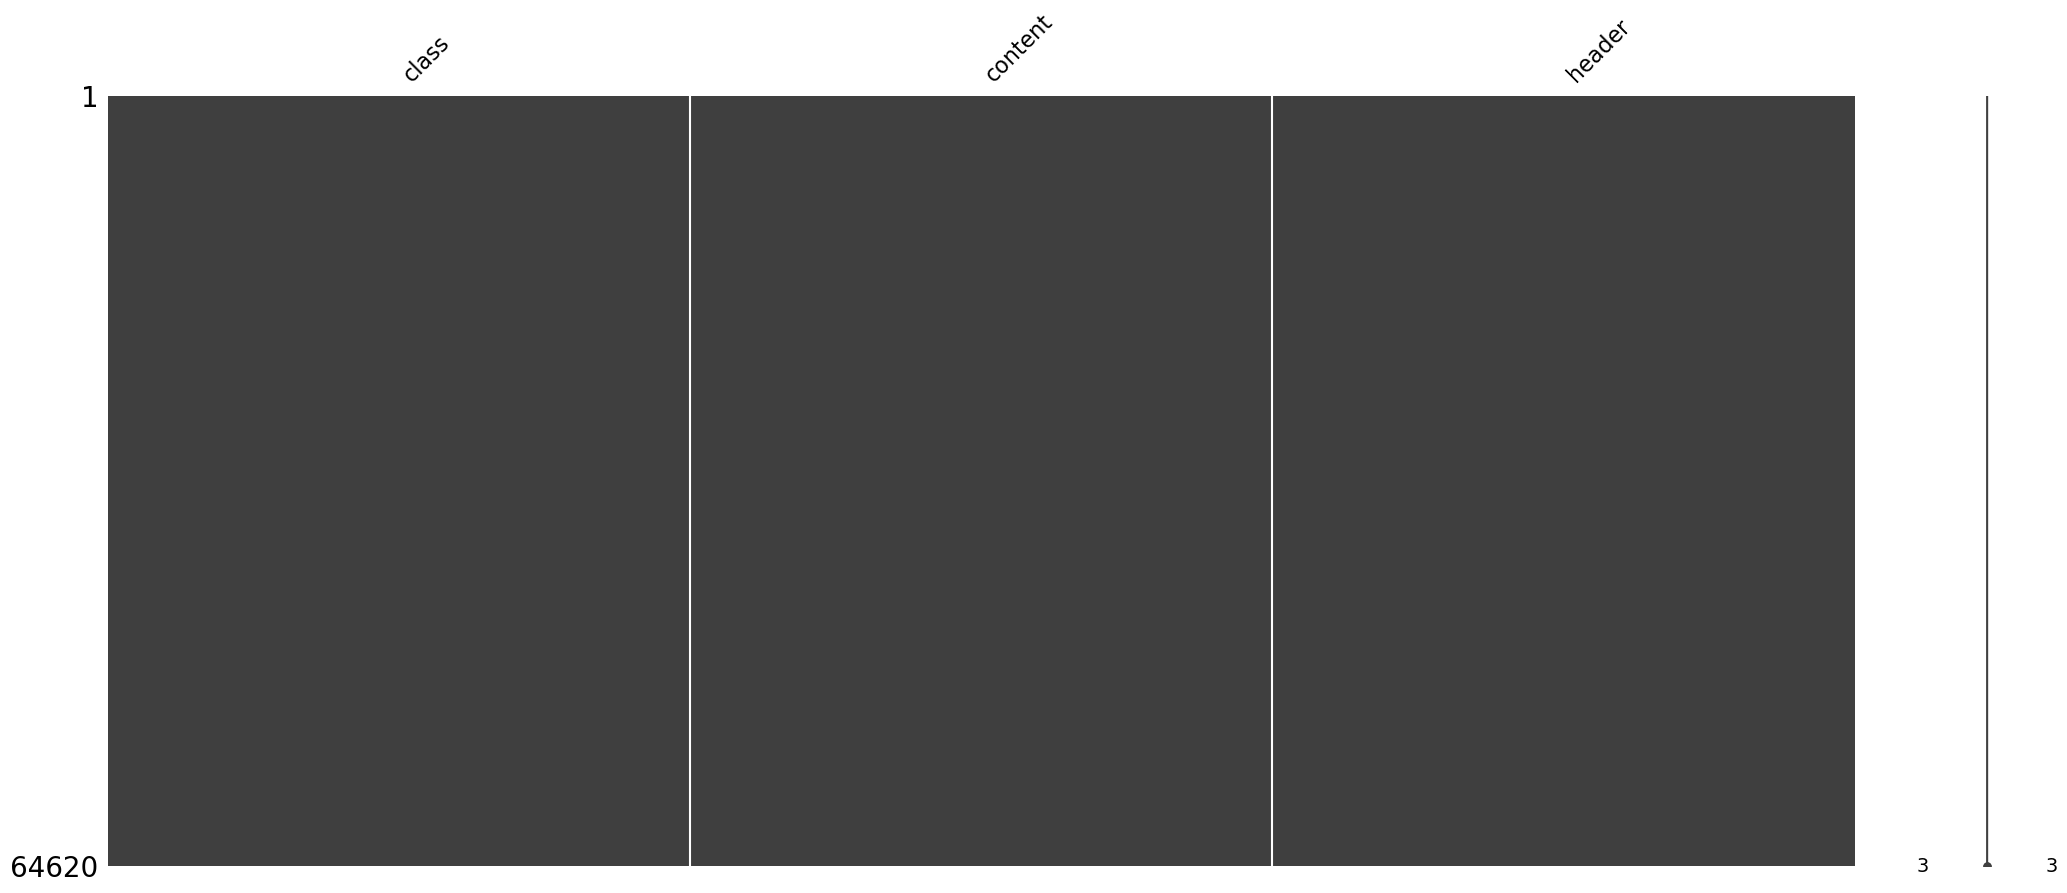

In [12]:
# remove duplicants in data frame
data_frame.drop_duplicates(inplace=True)
# remove constant features
data_frame = data_frame.loc[:, (data_frame != data_frame.iloc[0]).any()]

msno.matrix(data_frame)

# shuffling data
data_frame = data_frame.sample(frac=1).reset_index(drop=True)
display(data_frame)

### 2-3. Split to train set and test set

In [13]:
all_y = data_frame["class"].values  # all label values
all_x = data_frame.drop(columns=["class"]).values # all features' values

# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((64620,), (64620, 2), (51696, 2), (12924, 2), (51696,), (12924,))

### 2-4. Evaluate if sets and data is representative
ref: https://amol-kulkarni.com/project/naivebayes/ 

In [14]:
def get_probability_count(label: np.array, classes: List[str] = [0, 1]) -> List[int]:
    """
    Get the occurence of class types in the label values array;
    label: [n*1] array for label values; based on current feature
    0 -> non spam
    1 -> spam

    return:
    label_class_counts: [label=0 count, label=1 count]
    """
    label_class_counts = []
    for label_class_type in classes:
        label_class_counts.append(list(label).count(label_class_type))
    return label_class_counts


# in raw data
ham, spam = get_probability_count(all_y)
print("Non-spam in raw data: {}".format(ham/(ham+spam)))
print("Spam in raw data: {}".format(spam/(ham+spam)))

# in test set
ham, spam = get_probability_count(y_train)
print("Non-spam in raw data: {}".format(ham/(ham+spam)))
print("Spam in raw data: {}".format(spam/(ham+spam)))

Non-spam in raw data: 0.3368307025688641
Spam in raw data: 0.6631692974311358
Non-spam in raw data: 0.33530640668523676
Spam in raw data: 0.6646935933147632


We can see that the data we have is not necessarily representative. As in practice most emails should be non-spam.  
This also suggests that this proportion might bring in bias in the training stage. For example, Complement Naive Bayes is particularly suited to work with imbalanced datasets, whilst Multinomial Naive Bayes does not perform well in this scenario.

## 3. Content Feature Extraction

ref: https://www.analyticsvidhya.com/blog/2022/05/a-complete-guide-on-feature-extraction-techniques/#:~:text=If%20we%20have%20textual%20data,is%20also%20called%20text%20vectorization.  
ref: https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created  

Textual data is not computable so it must be transformed into numeric data such as a vector space model.  
There are different types of extraction techniques, e.g. Countvectorizer, TF-IDF.  

Tfidf is meant for rendering more importance to the rare words. It so happens that if you rely on word counts alone, the unimportant words like ‘the’ , ‘and’ etc. will get more importance because they tend to get used more often.  

There is no conclusion to which is better, but from personal use, TF-IDF will usually be stronger in modeled data, e.g. spam classifier.

### 3-1. Vectorizers

It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.   
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"

In [ ]:
def extract_CountVectorizer(data_train, data_test=None, max_features: int = 100, min_df: float = 0.01):
    # build the model for count vectorizer
    vectorizer = CountVectorizer(min_df=0.01, max_features = max_features)
    # fit into training data
    model = vectorizer.fit(data_train)
    feature_name = model.get_feature_names_out()
    features_train = model.transform(data_train).toarray()
    features_test = None
    if data_test:
        features_test = model.transform(data_test).toarray()
    return feature_name, features_train, features_test, model
    

In [ ]:
def extract_TfidfVectorizer(data_train, data_test=None, max_features: int = 100, min_df: float = 0.01):
    vectorizer = TfidfVectorizer(min_df=0.01, max_features = max_features, ngram_range=(1,1))
    # fit into training data
    model = vectorizer.fit(data_train)
    feature_name = model.get_feature_names_out()
    features_train = model.transform(data_train).toarray()
    features_test = None
    if data_test:
        features_test = model.transform(data_test).toarray()
    return feature_name, features_train, features_test, model

### 3.2 Raw Data Analyze

ref: https://www.pluralsight.com/guides/text-data-visualization-and-insights-in-python  

WordCloud is invoked for visualization. 
To install: `conda install -c conda-forge wordcloud`

This experiment also tests bar plot visualization. However, it does not offer an intuitive representation when the amount of terms is large.

In [ ]:
# the amount of features is large; this is not a go-to visualization method
def visualize_text_bar_plot(label, feature_train):
    
    freq_data_frame = pd.DataFrame(feature_train, columns=label)
    feature_mean_freq_dict = dict(freq_data_frame.mean())
    freq = [value for value in feature_mean_freq_dict.values()]
    plt.bar(range(len(label)), freq, tick_label=label)

In [ ]:
def draw_word_cloud(label, feature_train, max_words=200):
    plt.rcParams['font.sans-serif']='SimHei'
    freq_data_frame = pd.DataFrame(feature_train, columns=label)
    feature_mean_freq_dict = dict(freq_data_frame.mean())
    word_cloud = WordCloud(background_color="white",width=1000,height=1000, 
                           max_words=max_words,relative_scaling=0.5,normalize_plurals=False,
                          font_path='simhei.ttf', prefer_horizontal=1).generate_from_frequencies(feature_mean_freq_dict)
    plt.imshow(word_cloud)

To get a better idea on if the features vectorized and extracted can be representive, we run the extraction based on classes(spam/ham) first to observe the data.  
Max feature amount is set to 100; This can help us see if the vectorization on all contents can represent two classes.

In [ ]:
all_contents = [row[0] for row in x_train]

all_spam_contents = [all_contents[i] for i in range(0, len(all_contents)) if y_train[i] == 1]
all_ham_contents = [all_contents[i] for i in range(0, len(all_contents)) if y_train[i] == 0]

In [ ]:
# for spam emails
# under CountVectorizer
feature_name, features_value, features_test, model = extract_CountVectorizer(all_ham_contents, None, 100, 0.01)
draw_word_cloud(feature_name, features_value, 100)
# under TF-IDF
feature_name, features_value, features_test, model = extract_TfidfVectorizer(all_ham_contents, None, 100, 0.01)
draw_word_cloud(feature_name, features_value, 100)

# the same for spam emails

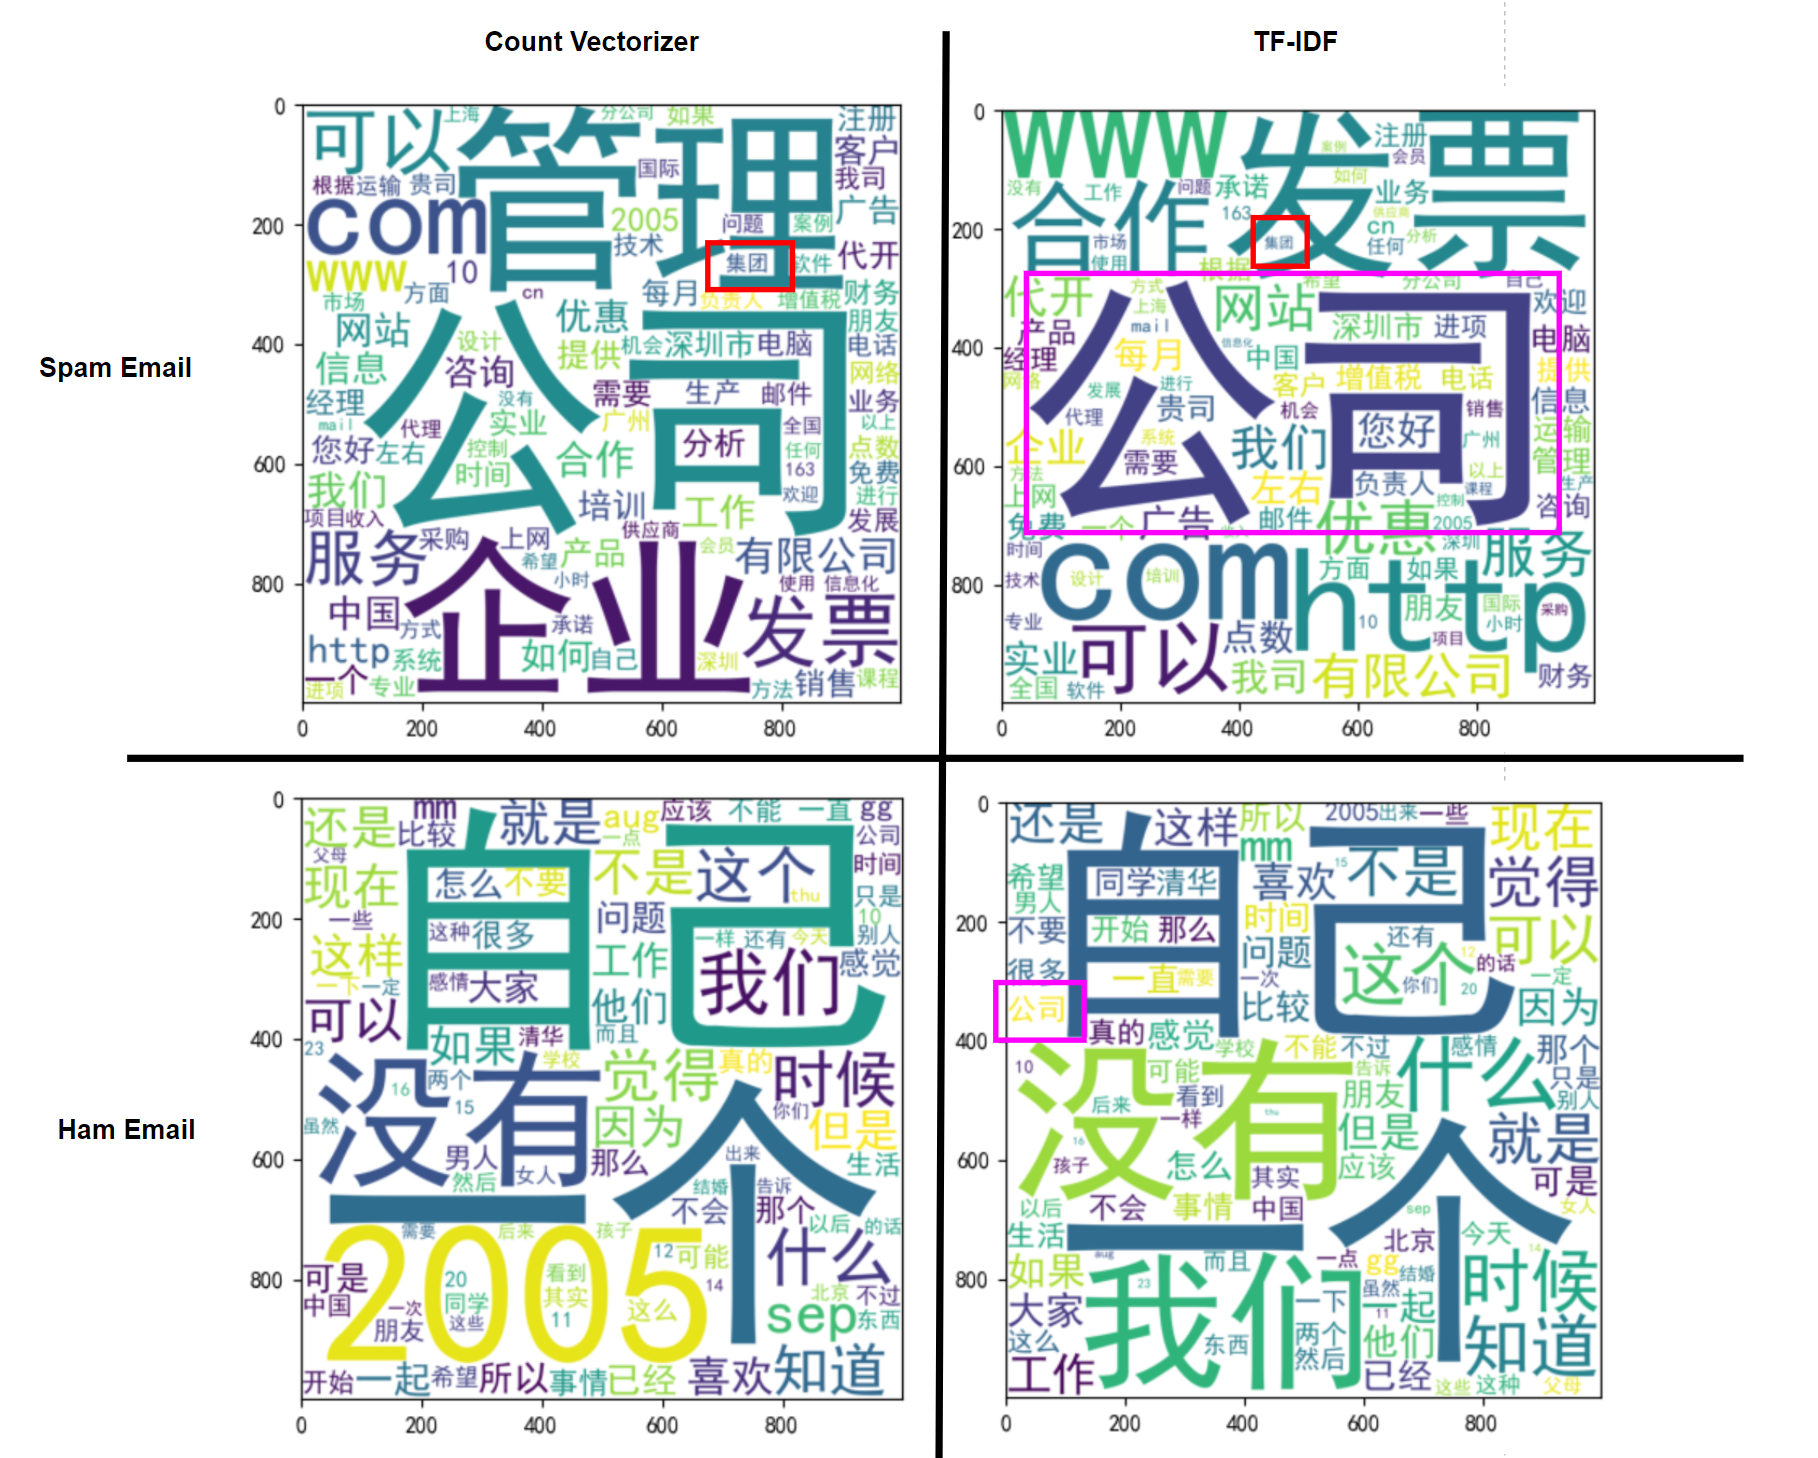

#### Observation 1
ref: https://enjoymachinelearning.com/blog/countvectorizer-vs-tfidfvectorizer/?expand_article=1  

We can see that CountVectorizer and TF-IDF have main differences on feature extraction results for low-mid frequency words.   

The most frequent terms are identical from 2 methods on the same set of data. For less-regular terms, The frequency(importance) of a word is different. For example:  
1. on spam emails' contents, "集团" in countvectorizer is more important than in TF-IDF.  
2. Numeric terms extracted by countvectorizer has higher frequency than in TF-IDF.  
This could be because count vectorizer only counts the appearance times for a term. Whist TF-IDF treats all words equally without penelty.  
For example, for english contents extraction, words like "it", "is" etc. are seen as highly valuable by countvectorizer.  

---

#### Observation 2
We need to evaluate if the features extracted can represent the classification characteristics for both spam and ham emails.  
From the image above, it is easy to see that key feature terms and associated frequencies for two types have wide variations.  
For example, term "公司" has high importance (repetition) in spam emails, and low in ham emails.  

Terms that have such characteristics may be a "valuable and effective" feature for the spam classifier.



### 3.3 Explainability and Interpretability

A logistic regression is used to validate the Shapley values of extracted features from email contents.

ref: https://www.thepythoncode.com/article/explainable-ai-model-python  
conda install: `conda install -c conda-forge shap`  

In order to import shap, run following in conda env bash:  
`conda install -c conda-forge ipywidgets`  
`jupyter nbextension enable --py widgetsnbextension`

In [ ]:
def get_SHAP_mean_graph(all_features, l_model, feature_names):
    term_shap_list = []
    
    background_c = shap.maskers.Independent(all_features, max_samples=1000)  # this would conceal some features
    explainer = shap.Explainer(l_model, background_c, feature_names=feature_names)
    shap_values_c = explainer(all_features)
    shap_values_dict = dict(pd.DataFrame(shap_values_c.values).abs().mean())
    
    i = 0
    for value in shap_values_dict.values():
        term_shap_list.append([feature_names[i], value])
        i += 1
        
    sorted_term_shap = sorted(term_shap_list, key=lambda x:x[1], reverse=True)
    
    # display top 100 terms that have best interpretability over the whole train model set
    features = [sorted_term_shap[i][0] for i in range(0, 100)]
    shaps = [sorted_term_shap[i][1] for i in range(0, 100)]
    
    #draw bar plot
    fig, ax = plt.subplots()
    
    ax.barh(features, shaps, align='center')
    ax.set_yticks(features, labels=features)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Shap')
    
    fig.set_figheight(15)
    fig.set_figwidth(10)
    
    plt.show()
    
    

In [ ]:
l_model = LogisticRegression(max_iter=500000)

# here we divide the train set to train set and validation set
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
all_contents = [row[0] for row in x_train]
train_contents = [row[0] for row in x_train1]
validate_contents = [row[0] for row in x_val]


# vectorize: run for both count vectorizer and tf-idf
vectorizer = TfidfVectorizer(min_df=0.1)
model = vectorizer.fit(train_contents)

feature_name = vectorizer.get_feature_names_out()
features_train = vectorizer.transform(train_contents).toarray()
features_val = vectorizer.transform(validate_contents).toarray()
features_all = vectorizer.transform(all_contents).toarray()


l_model.fit(features_train, y_train1)

get_SHAP_mean_graph(features_all, l_model, feature_name)


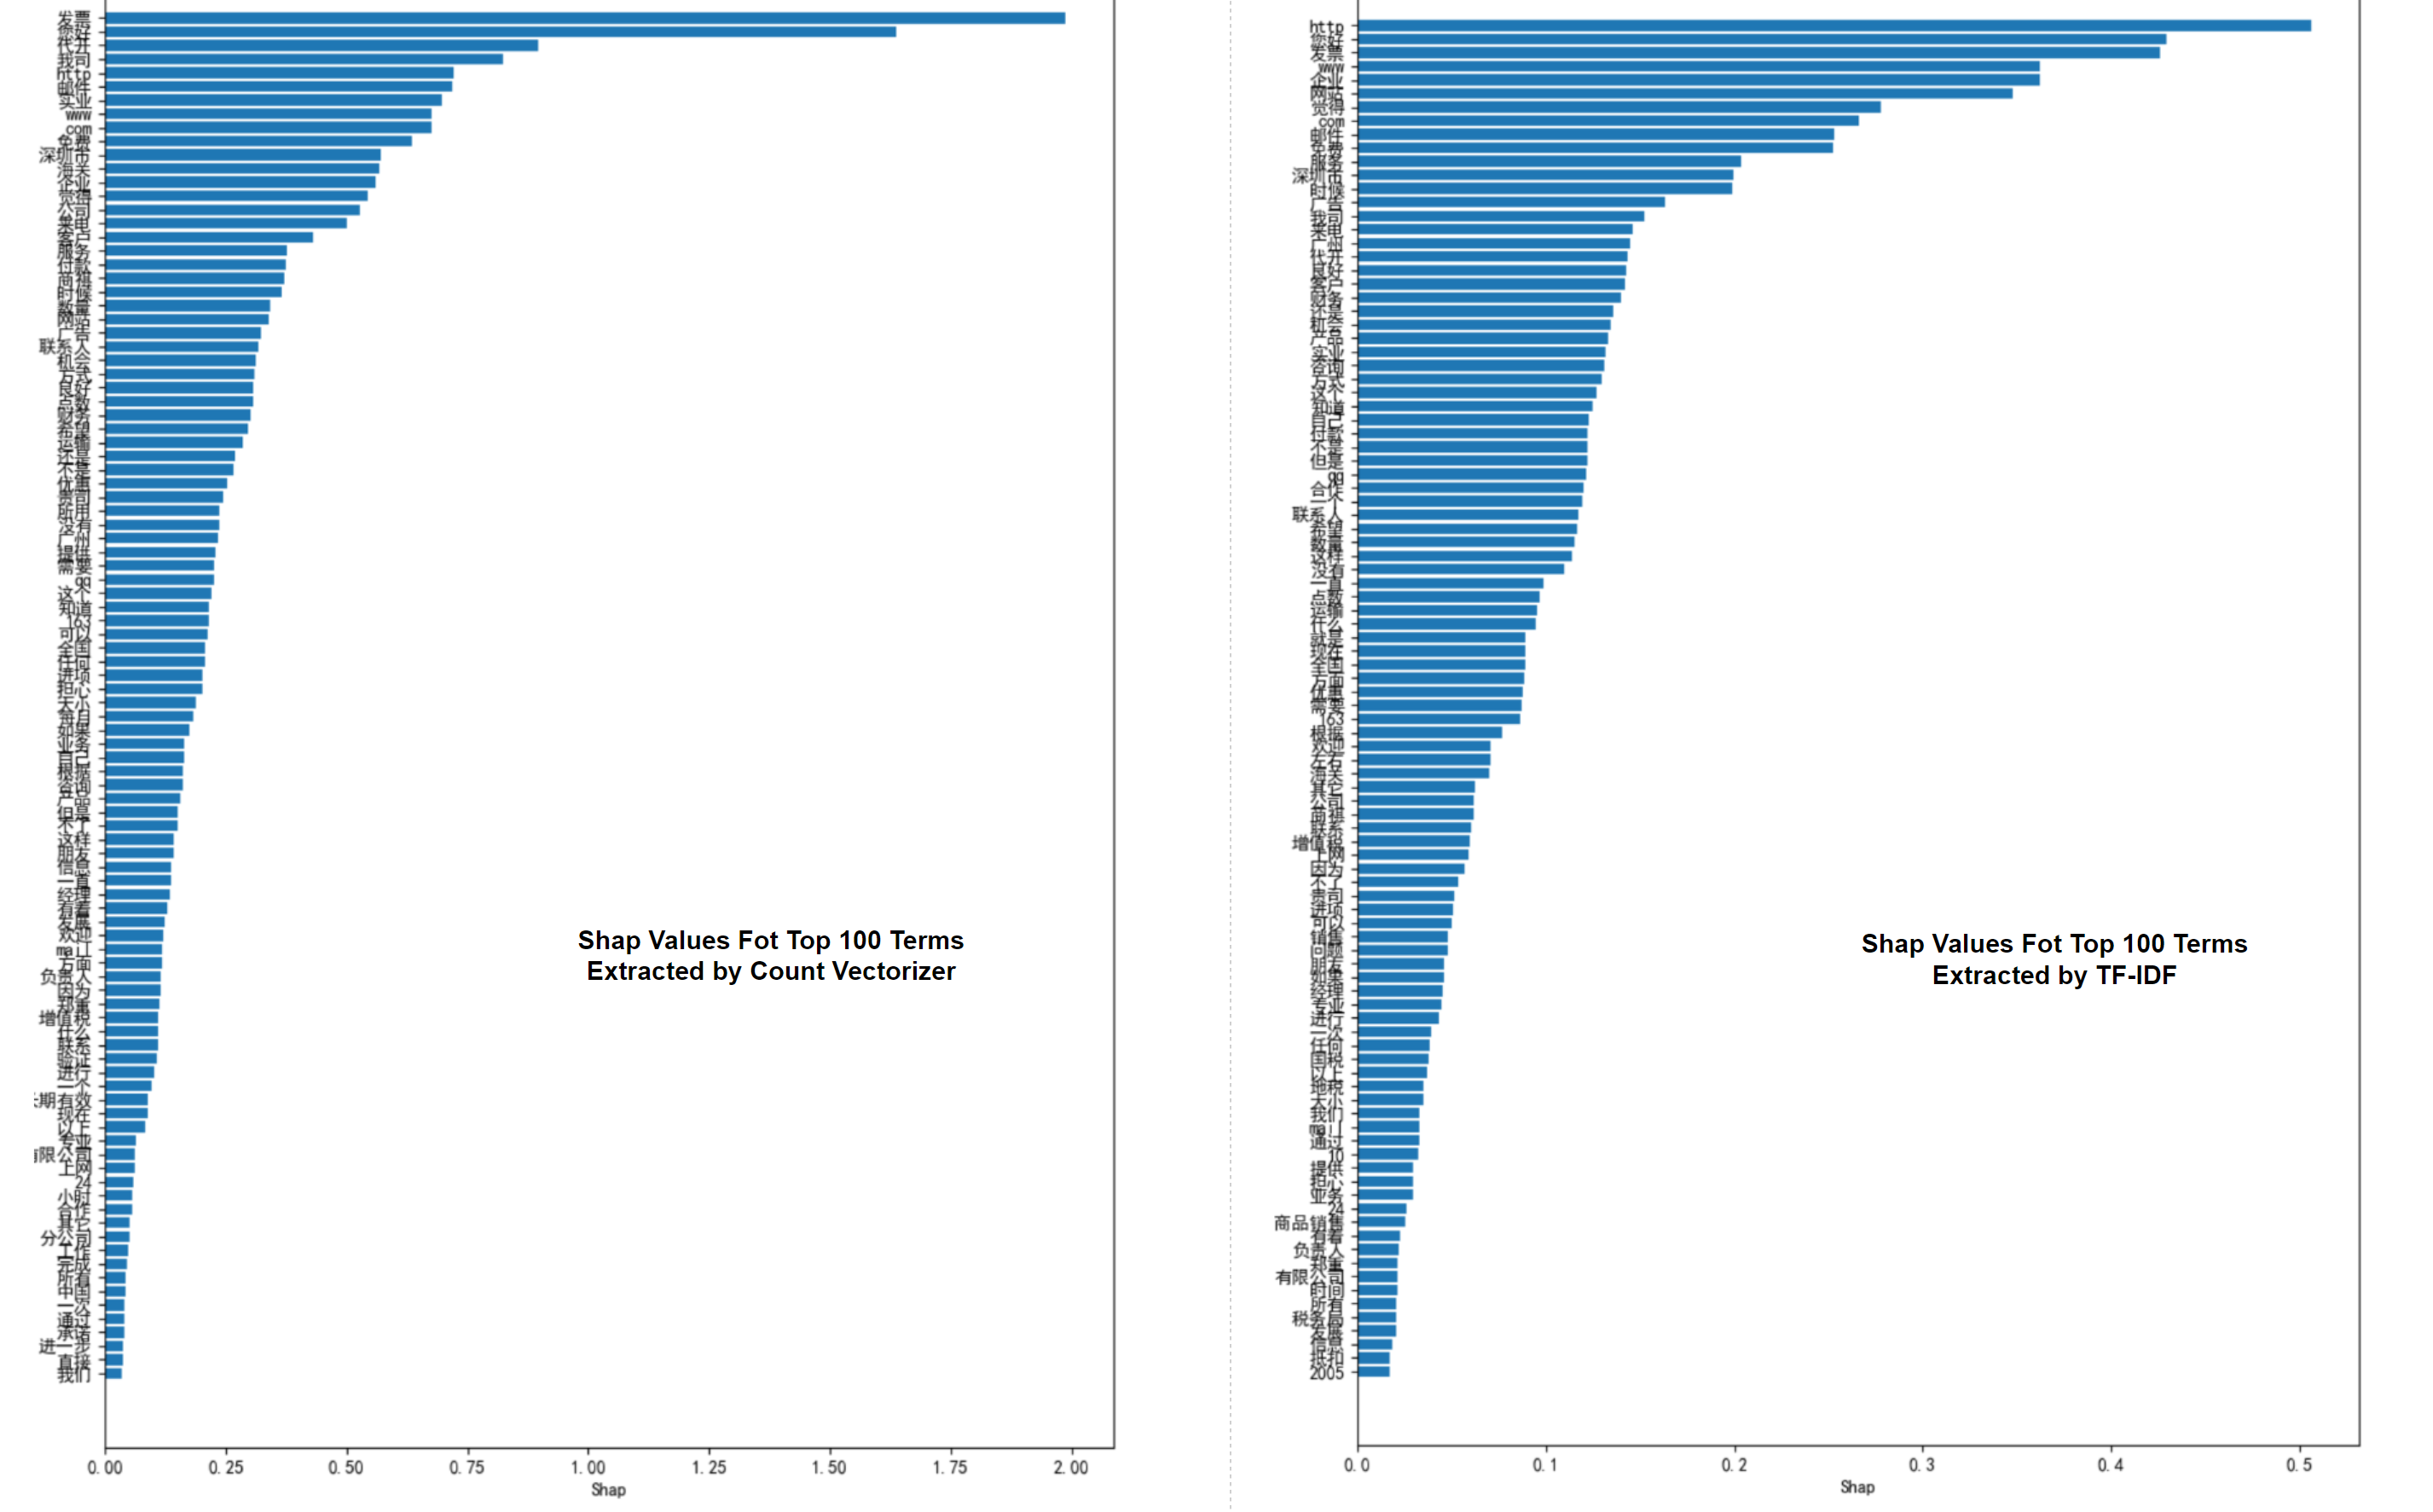

ref: https://datascientest.com/en/shap-what-is-it#:~:text=SHapley%20Additive%20exPlanations%2C%20more%20commonly,each%20feature%20or%20feature%20value.  

The graph above is the shapley values for top 100 extracted term features.  

SHAP is thus a technique that allows to explain the predictions of Machine Learning models in a versatile and powerful way. This method is agnostic, consistent, and can handle complex model behavior. SHAP is particularly useful for understanding how a model works, identifying important features, and explaining the result of predictions.  

Using count vectorizer, we can see that the importance of terms drops down massively from the top-2 terms to the less-important ones; whilst TF-IDF has a more gentle downward trend.  

Compare this graph with the upper wordcloud:  
1. based on the analysis, the frequencies of term "公司" has a huge differences between non-spam and spam. Judging only by this, we could identify this term as a feature with high explainability over the classification rule (count is better).
2. In shap graph, "公司" has more interpretability over the whole model built by count vectorizer, compared to TF-IDF.

The reason could be:
Our data set itself is imbalanced. Thus, by calculating only the count of the term appearances, it suggests a high interpretability as we have more non-spam emails.  

At this point, we could make an assumption that under a balanced data set, TF-IDF may work better. With an unbalanced data set, features extracted by count may have more significance, but can also introduce bias.  


## 4. Sklearn Naive Bayes

In this section, we analyze the performance of different vectorization and Naive Bayes models on train set with cross validation mean scores.

In [ ]:
# initialize test parameters

accuracy_scr, recision_scr, recall_scr, f1_scr = [], [], [], []

vectorizers = ["countVectorizer", "TFIDF"]

max_features = [50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 2500, 3000]

multinomial_nb =  MultinomialNB()
bernoulli_nb =  BernoulliNB()
complement_nb = ComplementNB()
classifiers = [multinomial_nb, bernoulli_nb, complement_nb]


In [ ]:
# run tests

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


for classifier in classifiers:
    for vectorizer in vectorizers:
        for max_feature in max_features:
            print("classifier: {}, vectorzier: {}, max_feature: {}".format(classifier, vectorizer, max_feature))
            
            mean_cross_val = {}
            
            if vectorizer == "countVectorizer":
                feature_name, features_train, features_test, model = extract_CountVectorizer(
                    train_contents, validate_contents, max_features = max_feature
                )
                # fit model on all train set X
                train_all_X = model.transform(all_contents).toarray()
                results = cross_validate(classifier, train_all_X, y_train, cv=5, scoring=scoring)
                
                #get mean
                for key in results.keys():
                    mean_cross_val[key] = np.mean(results[key])
                print("cross validate: \n {} \n \n".format(mean_cross_val))
                
                
            if vectorizer == "TFIDF":
                feature_name, features_train, features_test, model = extract_TfidfVectorizer(
                    train_contents, validate_contents, max_features = max_feature
                )
                train_all_X = model.transform(all_contents).toarray()
                results = cross_validate(classifier, train_all_X, y_train, cv=5, scoring=scoring)
                
                #get mean
                for key in results.keys():
                    mean_cross_val[key] = np.mean(results[key])
                print("cross validate: \n {} \n \n".format(mean_cross_val))    
                
            
        

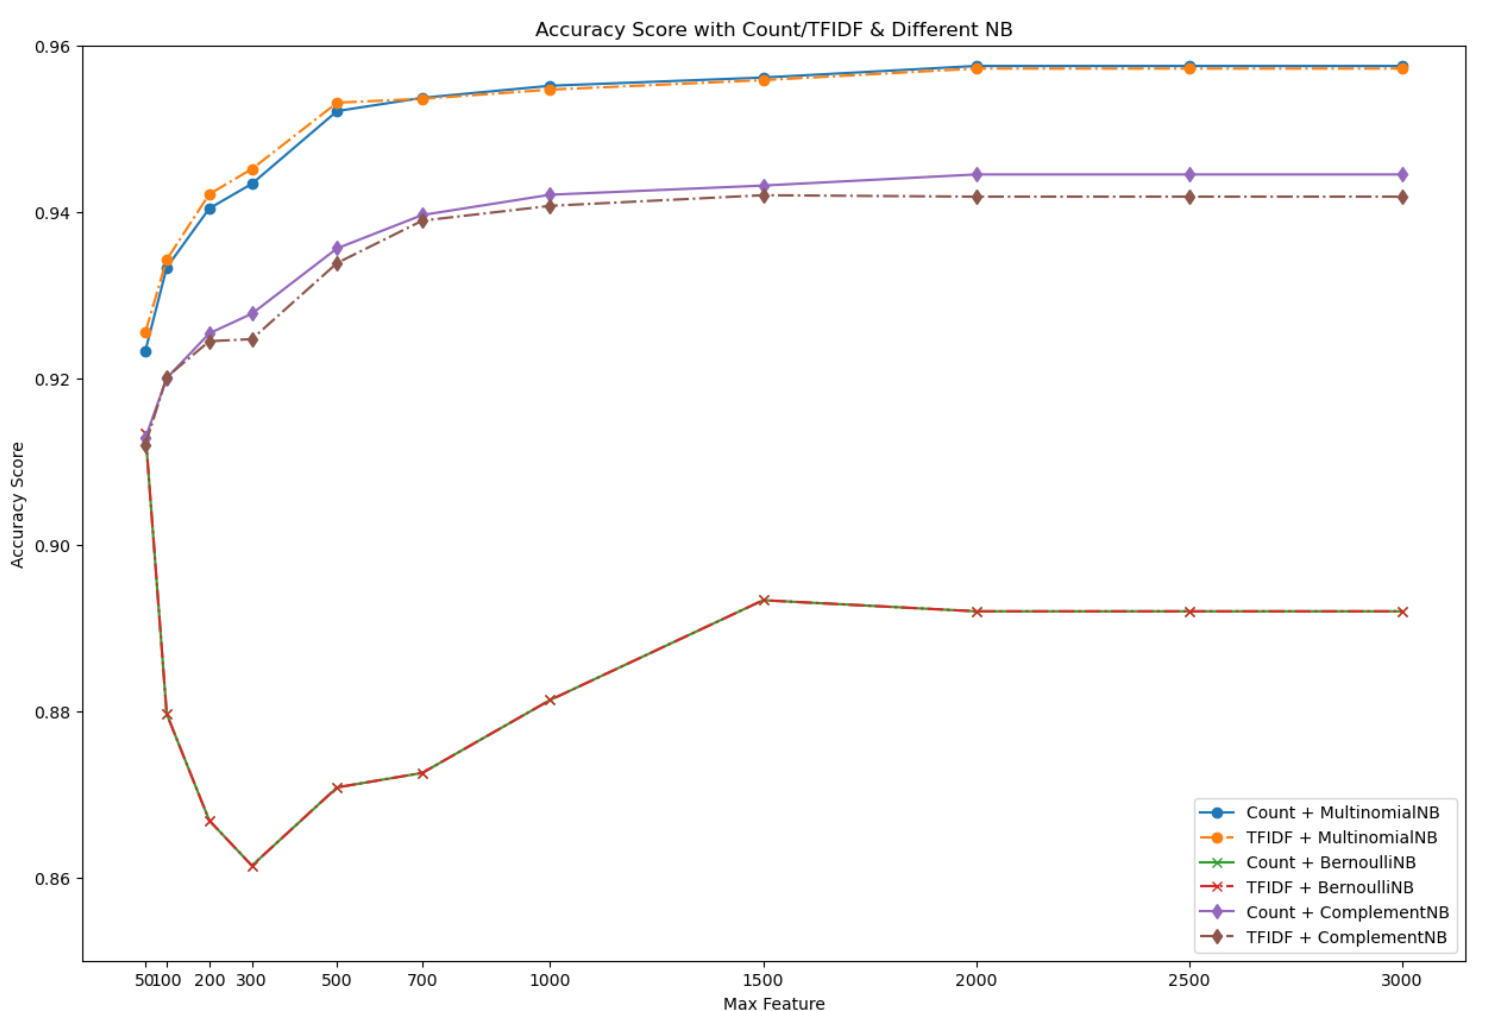
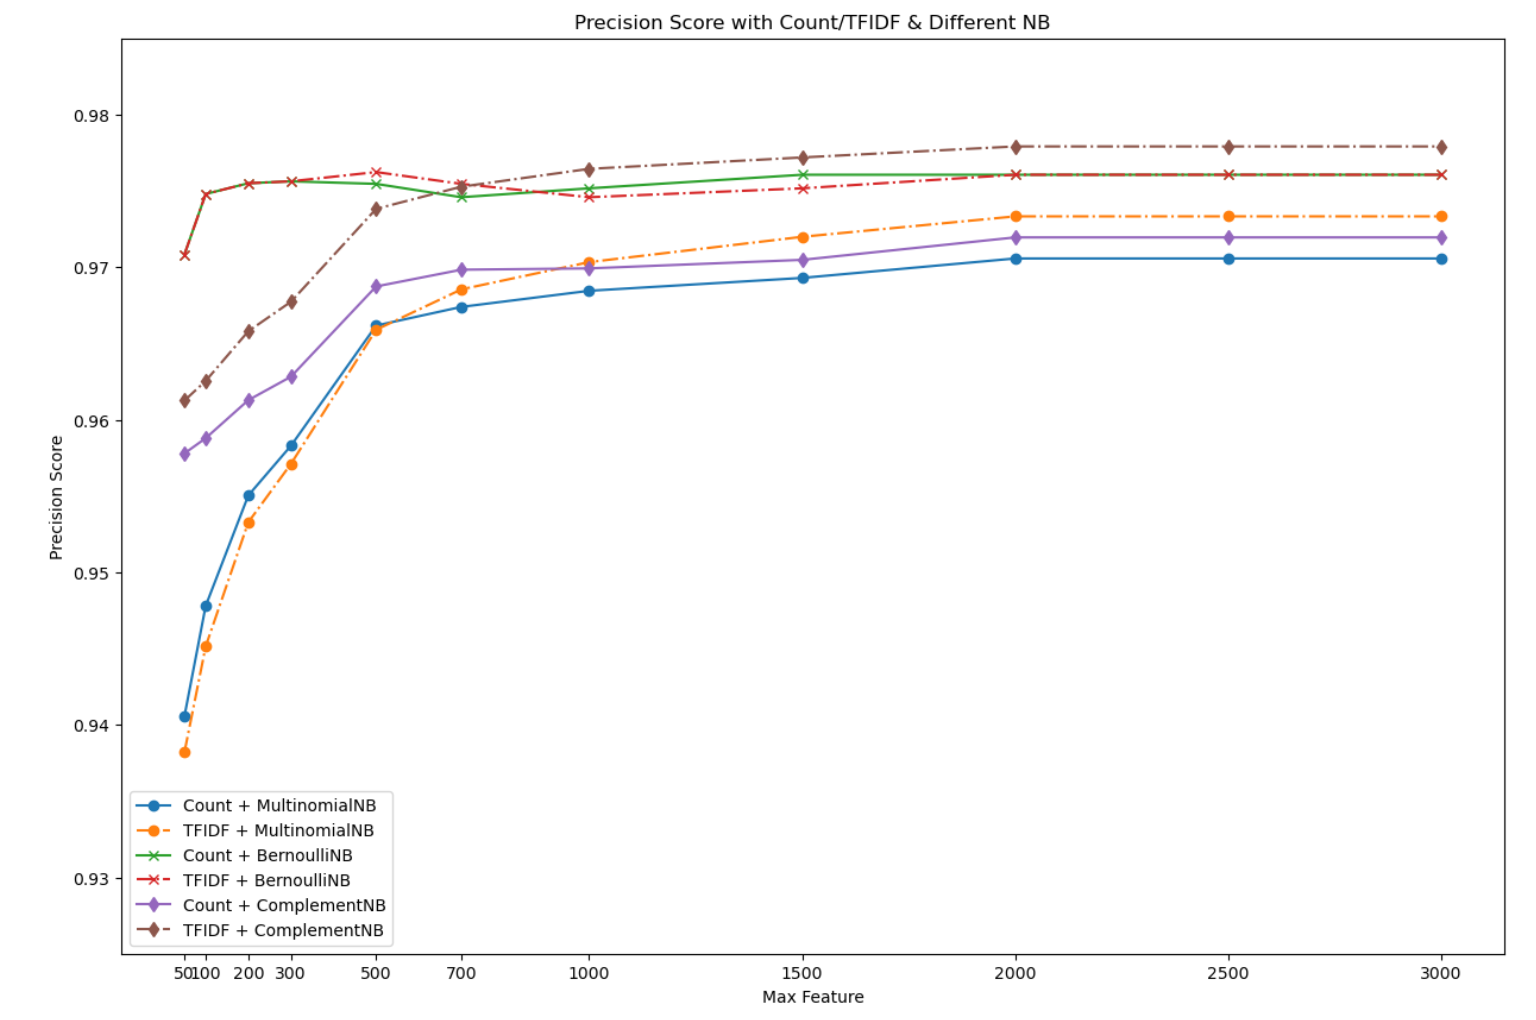
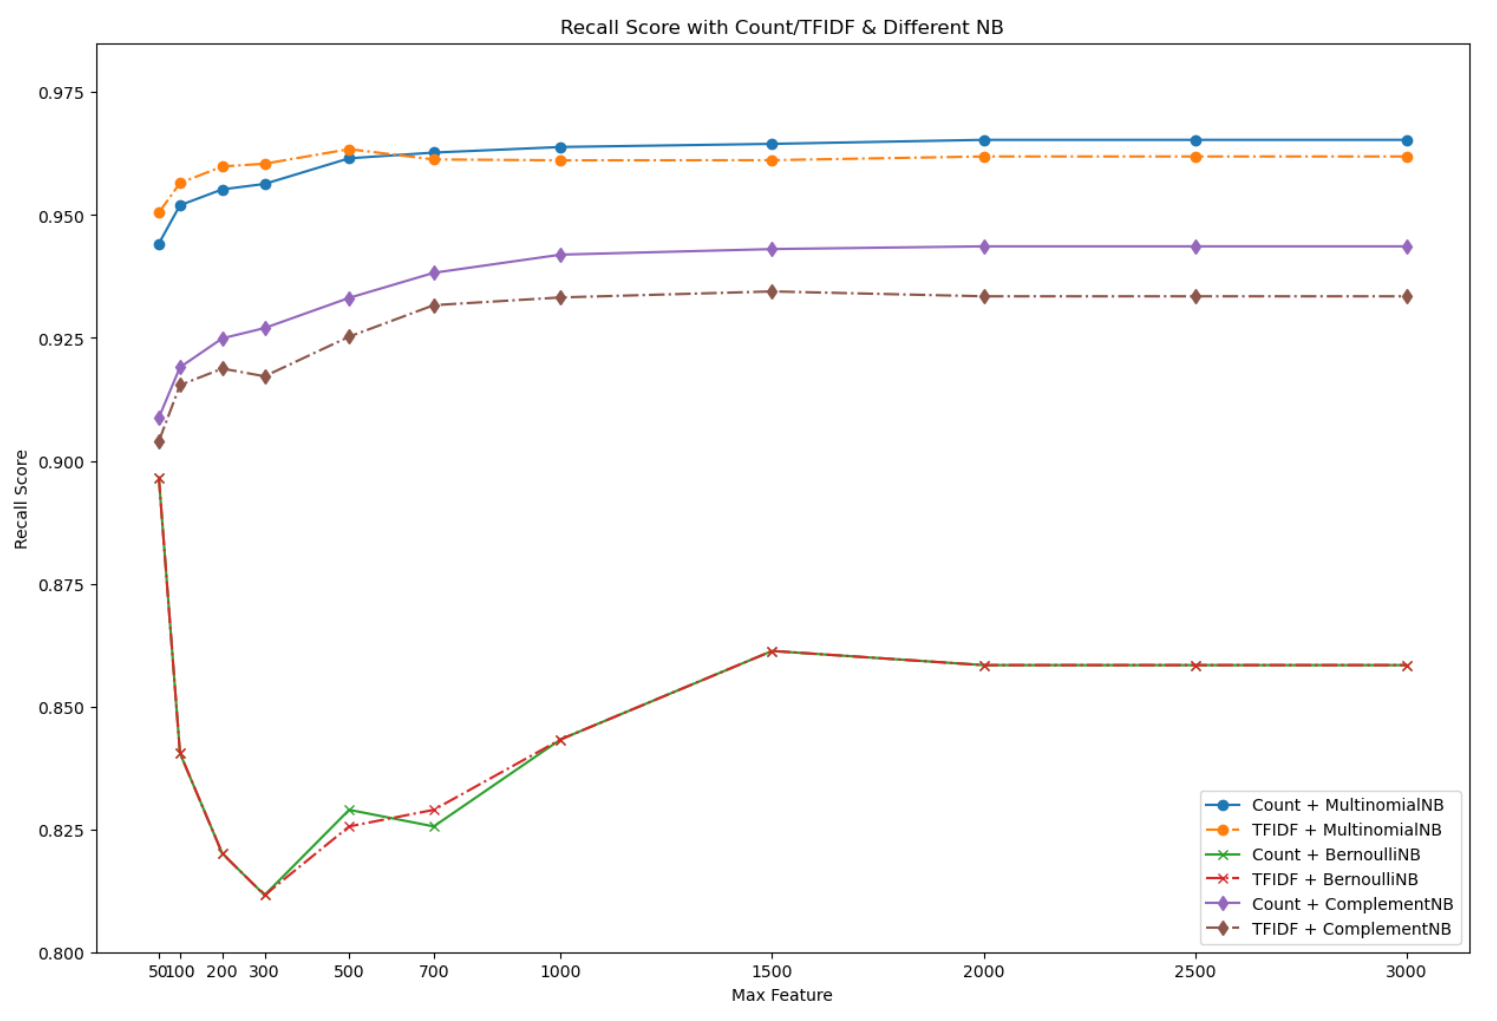
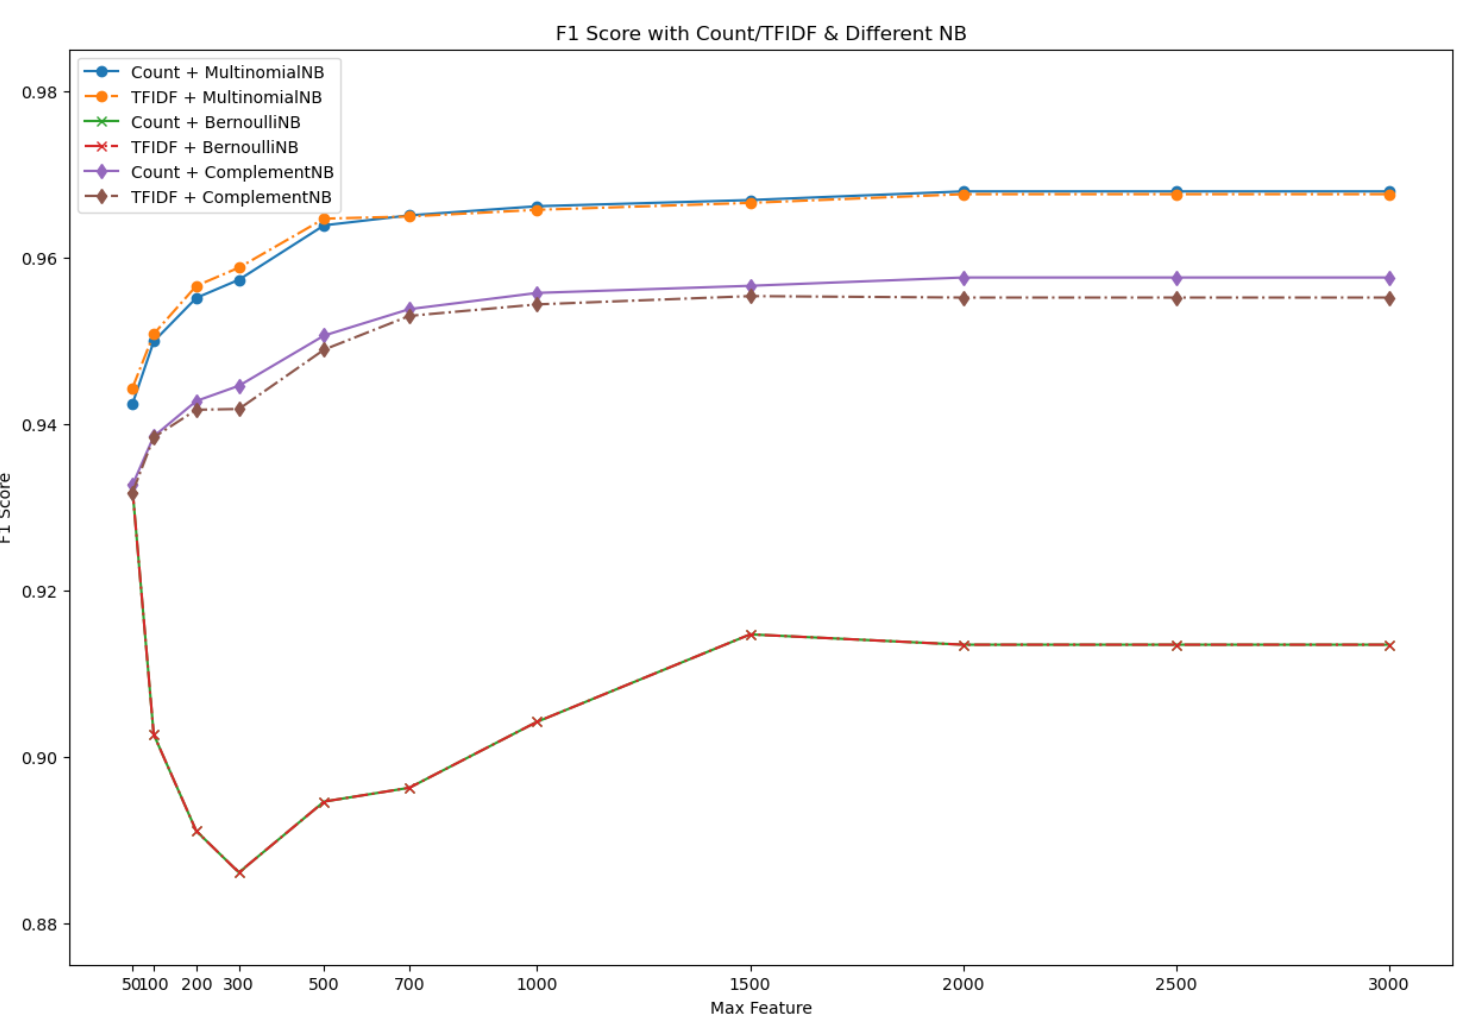

$Accuracy$ = $(True Positive + True Negative)$ $\div$ $(True Positive + False Positive + True Nagative + False Negtive)$    
$Precision$ = $True Positive$ $\div$ $(True Positive + False Positive)$    
$Recall$ = $True Positive$ $\div$ $(True Positive + False Negative)$    
$F1$ = $2$ $\times$ $Precision$ $\times$ $Recall$ $\div$ $(Precision + Recall)$

### 4-1. Accuracy Score

ref: https://deepchecks.com/how-to-check-the-accuracy-of-your-machine-learning-model/  

Overall accuracy in machine learning classification models can be misleading when the class distribution is imbalanced, and it is critical to predict the minority class correctly. In this case, the class with a higher occurrence may be correctly predicted, leading to a high accuracy score, while the minority class is being misclassified. This gives the wrong impression that the model is performing well when it is not.  
This means to validate which model performs better on the given data set can not rely only on the accuracy score.

Reading from the accuracy score graph, we could see that Bernoulli Naive Bayes does not have good prediction performance as the other Naive Bayes models. It reaches the lowest accuracy when the max feature amount is around 300. Vectorizing by count or TFIDF works the same for Bernoulli NB. 

Both MultinomialNB and ComplementNB accuracy scores have a upward trend as the max feature amount grows up, then trending towards stability.
For these two models, vectorized by Count or TF-IDF does not have huge differences over accuracy. But in general, count method performs slightly better.

MultinomialNB gives out the best accuracy among three NB models, which indicates, as our data set is unbalanced, that multinomialNB may not give reliable results.


### 4-2. Precision Score and Recall Score

ref: https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/#:~:text=What%20is%20Precision%20Score%3F,false%20positives%20and%20false%20negatives.  

ref: https://towardsdatascience.com/precision-and-recall-a-simplified-view-bc25978d81e6  

Precision can be seen as a measure of quality, and recall as a measure of quantity.

Models need high recall when you need output-sensitive predictions. For example, predicting cancer or predicting terrorists needs a high recall, in other words, you need to cover false negatives as well. It is ok if a non-cancer tumor is flagged as cancerous but a cancerous tumor should not be labeled non-cancerous.  
Similarly, we need high precision in places such as recommendation engines, spam mail detection, etc. Where you don’t care about false negatives but focus more on true positives and false positives. It is ok if spam comes into the inbox folder but a really important mail shouldn’t go into the spam folder.


Based on the math formula, it is fair to say that precision score is a useful measure of the success of prediction when the classes are very imbalanced(here, spam:ham = 2:1).  
If in our model, we increase the proportion of ham emails, then the precision score should drop.

In general, multinomial has the lowest precision scores and highest recall scores. This suggests that most of its predicted labels are incorrect.  


BernoulliNB model has high precision and low recall, which indicates that ost of its predicted labels are correct when compared to the training labels.  

Precision and recall for ComplementNB have similar trends. Comparatively high precision and recall are desirable. To get a comprehensive understanding of the performance, F1 should also be introduced.
Another conclusion we can get from the precision graph and recall graph is that, with the ComplementNB classifier, vectorization with TF-IDF provides better prediction quality for both ham and spam emails, but count returns better result regarding the task (here to identify spam emails.) This means that using count vectorizer may misclassify ham emails to spam.

### 4-3. F1 Score

ref: https://stephenallwright.com/good-f1-score/  

F1 score is a popular way to measure models as it provides accurate results for both balanced and imbalanced dataset. In plain words, it tells you  the model’s balanced ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision). High F1 score usually suggests that the model predicts each observation correctly.

Based on the F1 score graph, and remains consistent to other graphs, Bernoulli is not a suitable classifier for our task (on our dataset).   

Count vectorization still performs slightly better than TF-IDF. As mentioned in Section 3.3, the reason could be: our data set itself is unbalanced. Thus, by calculating only the count of the term appearances, it suggests a high interpretability as we have more non-spam emails. However, if we were to generalize the model to a data set that is more similar to real-life ham/spam proportion, the performance may vary.  

### Conclusion

BernoulliNB takes, in most of the cases, only binary values. The most general example is where we check if each value will be whether or not a word appears in a document. That is a very simplified model. In cases where counting the word frequency is less important, Bernoulli may give better results. The advantages of BernoulliNB include better performance on some datasets with shorter documents. Due to the imbalance of our dataset, term frequency/importance can have more impact over the classification rule compared to whether a term has occurred in an email or not.  

Multinomial Naive Bayes does not perform very well on imbalanced datasets, and Complementary NB on the contrary. Imbalanced datasets are datasets where the number of examples of some class is higher than the number of examples belonging to other classes (see from section 4.2). If we only rely on F1 scores, we may have an opposite conclusion on multinomialNB’s behavior. Thus, in the next section, we will try balancing out the dataset and see how the balance of dataset can affect Bayes learning.  



## 5. Generalize Dataset and Behaviour on Test Set 

Based on Section4 conclusion, we will focus on testing Complementary Naive Bayes and Multinomial Naive Bayes.

### 5.1 Imbalanced Dataset: Spam > Ham

In [172]:
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((64620,), (64620, 2), (51696, 2), (12924, 2), (51696,), (12924,))

In [ ]:
multinomial_nb =  MultinomialNB()
complement_nb = ComplementNB()
classifiers = [multinomial_nb, complement_nb]

vectorizers = ["countVectorizer", "TFIDF"]

max_features = [50, 100, 200, 300, 500, 700, 1000, 1500, 2000]

all_contents_train = [row[0] for row in x_train]
all_contents_test = [row[0] for row in x_test]


# run tests

for classifier in classifiers:
    for vectorizer in vectorizers:
        for max_feature in max_features:
            print("classifier: {}, vectorzier: {}, max_feature: {}".format(classifier, vectorizer, max_feature))
            
            
            if vectorizer == "countVectorizer":
                feature_name, features_train, features_test, model = extract_CountVectorizer(
                    all_contents_train, all_contents_test, max_features = max_feature
                )
                classifier.fit(features_train, y_train)
                y_predict = classifier.predict(features_test)
                
                accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
                precision = precision_score(y_true=y_test, y_pred=y_predict)
                recall = recall_score(y_true=y_test, y_pred=y_predict)
                f1 = f1_score(y_true=y_test, y_pred=y_predict)
                
                print("accuracy: {} precision: {}, recall: {}, f1: {}".format(accuracy, precision, recall, f1))
                
                
            if vectorizer == "TFIDF":
                feature_name, features_train, features_test, model = extract_TfidfVectorizer(
                    all_contents_train, all_contents_test, max_features = max_feature
                )
                classifier.fit(features_train, y_train)
                y_predict = classifier.predict(features_test)
                
                accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
                precision = precision_score(y_true=y_test, y_pred=y_predict)
                recall = recall_score(y_true=y_test, y_pred=y_predict)
                f1 = f1_score(y_true=y_test, y_pred=y_predict)
                
                print("accuracy: {} precision: {}, recall: {}, f1: {}".format(accuracy, precision, recall, f1))


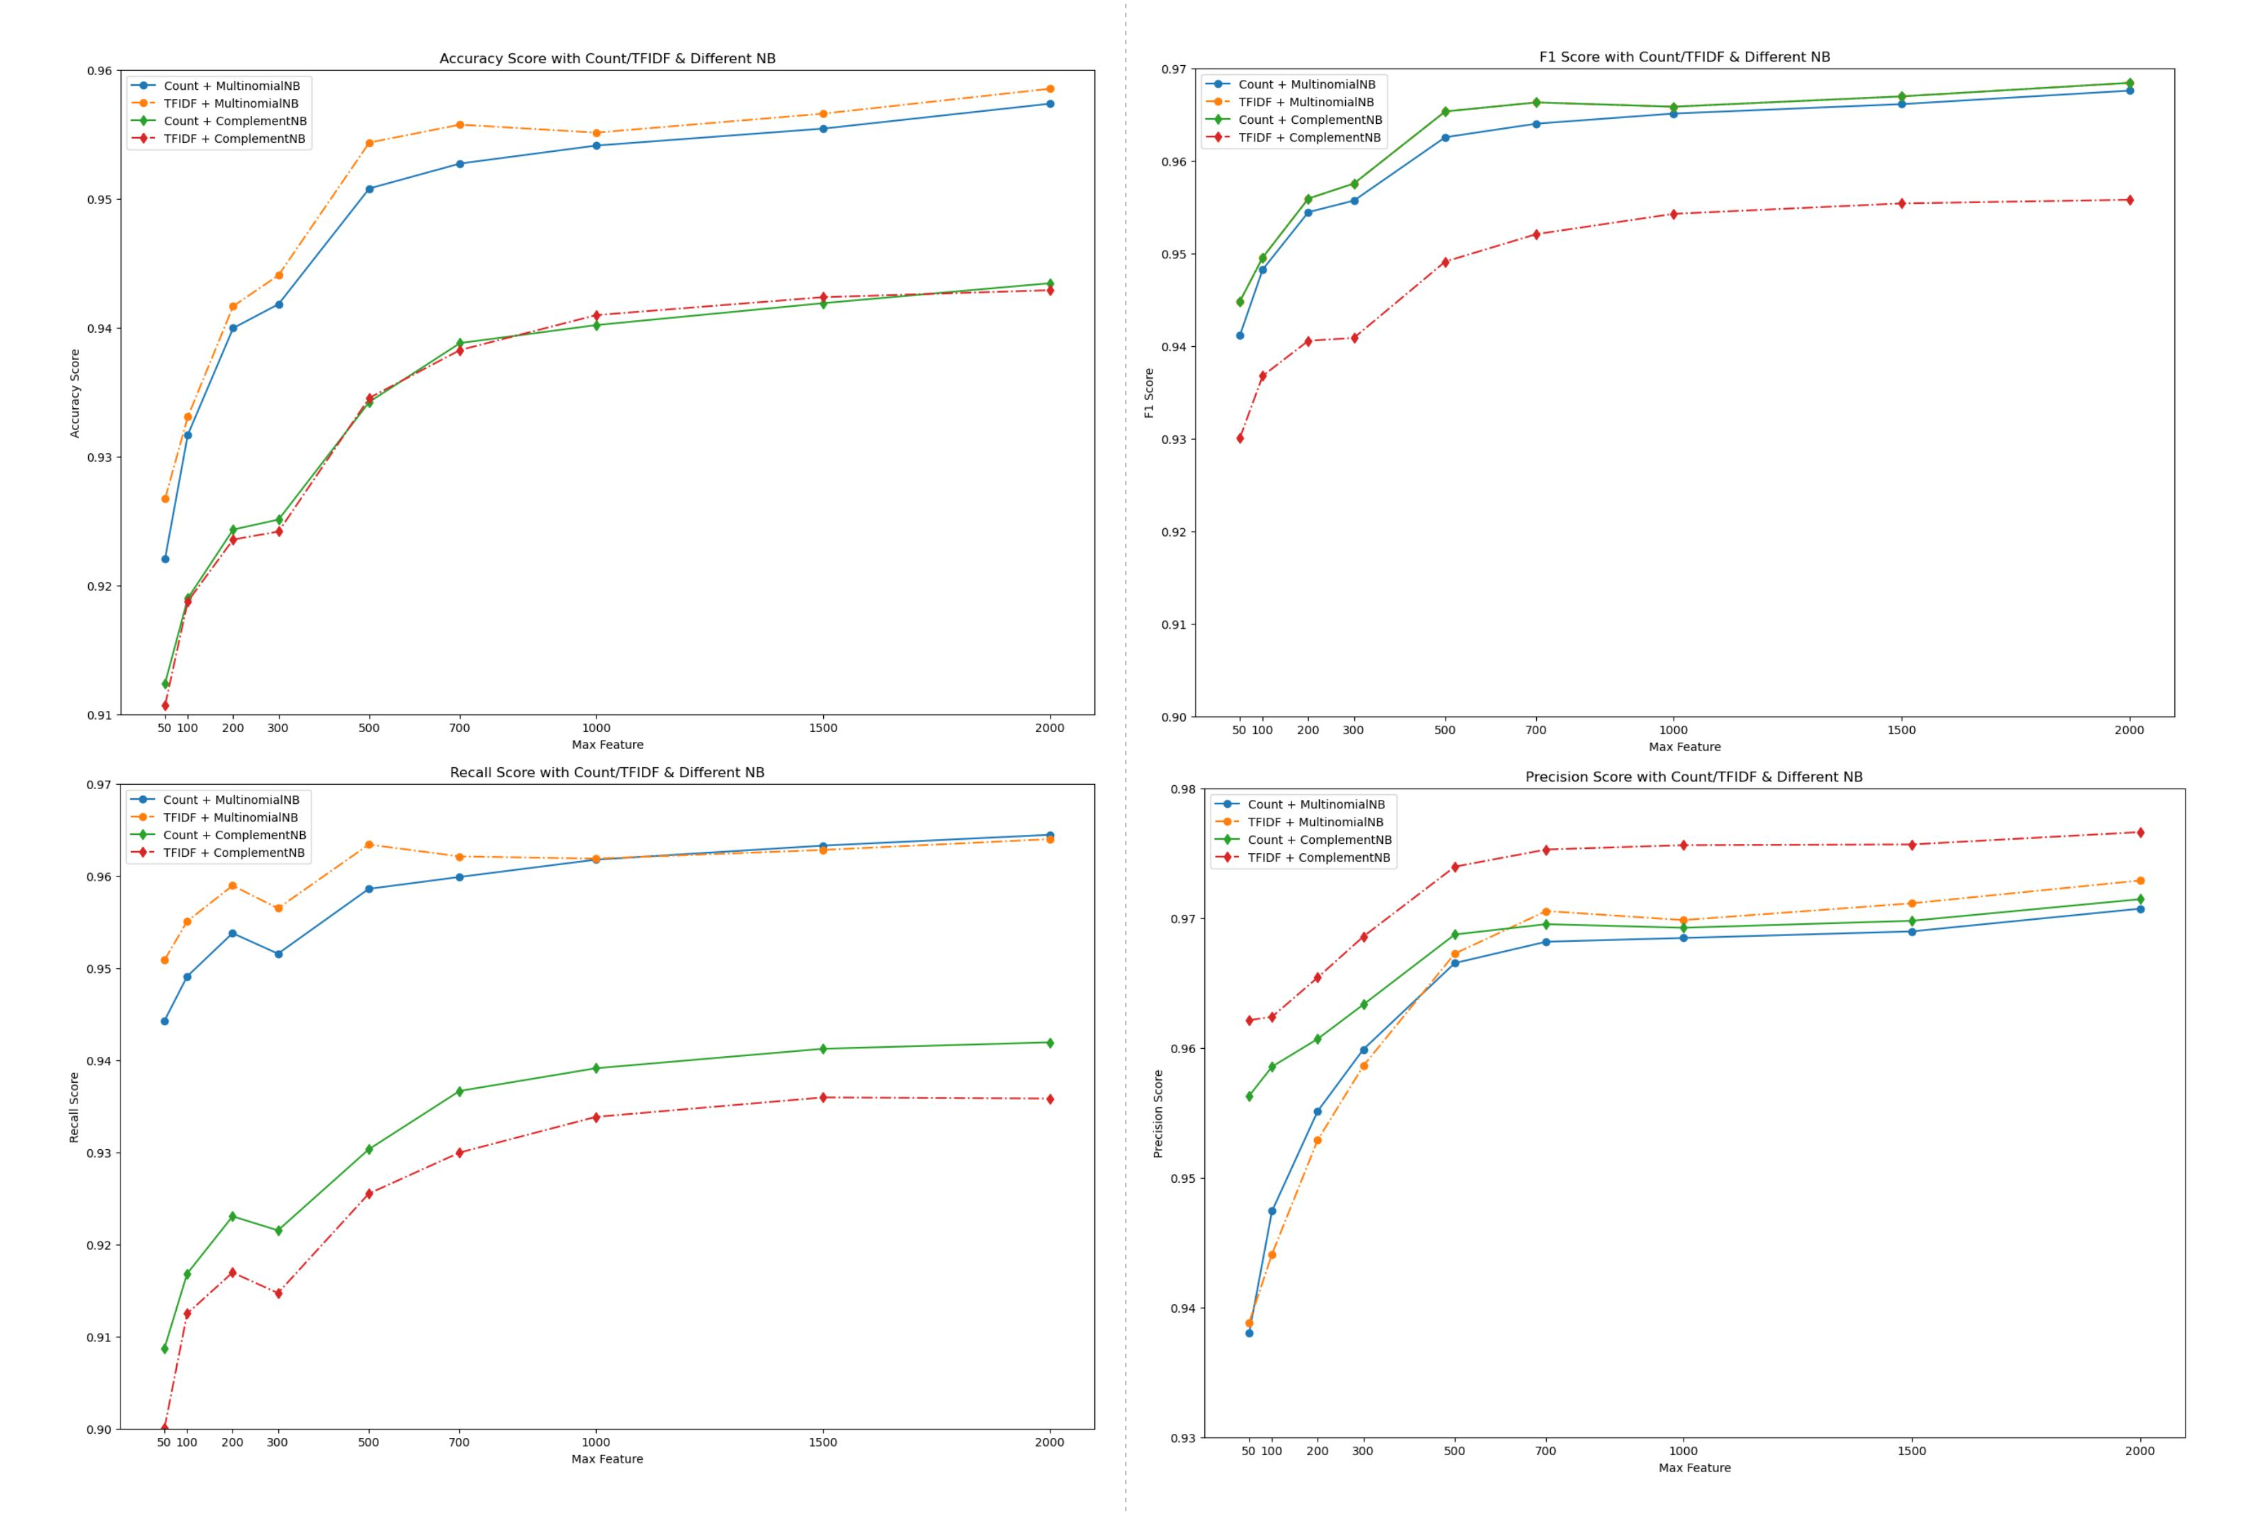

### 5.2 Balanced Dataset

In [195]:
non_spam_df = data_frame.loc[data_frame["class"]==0]
non_spam_amount = len(non_spam_df.index)

spam_df = data_frame.loc[data_frame["class"]==1]
spam_df = spam_df.sample(n=non_spam_amount)

balance_data_frame = pd.concat([non_spam_df, spam_df])
balance_data_frame = balance_data_frame.sample(frac=1).reset_index(drop=True)

In [197]:
all_y = balance_data_frame["class"].values  # all label values
all_x = balance_data_frame.drop(columns=["class"]).values # all features' values

# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((43532,), (43532, 2), (34825, 2), (8707, 2), (34825,), (8707,))

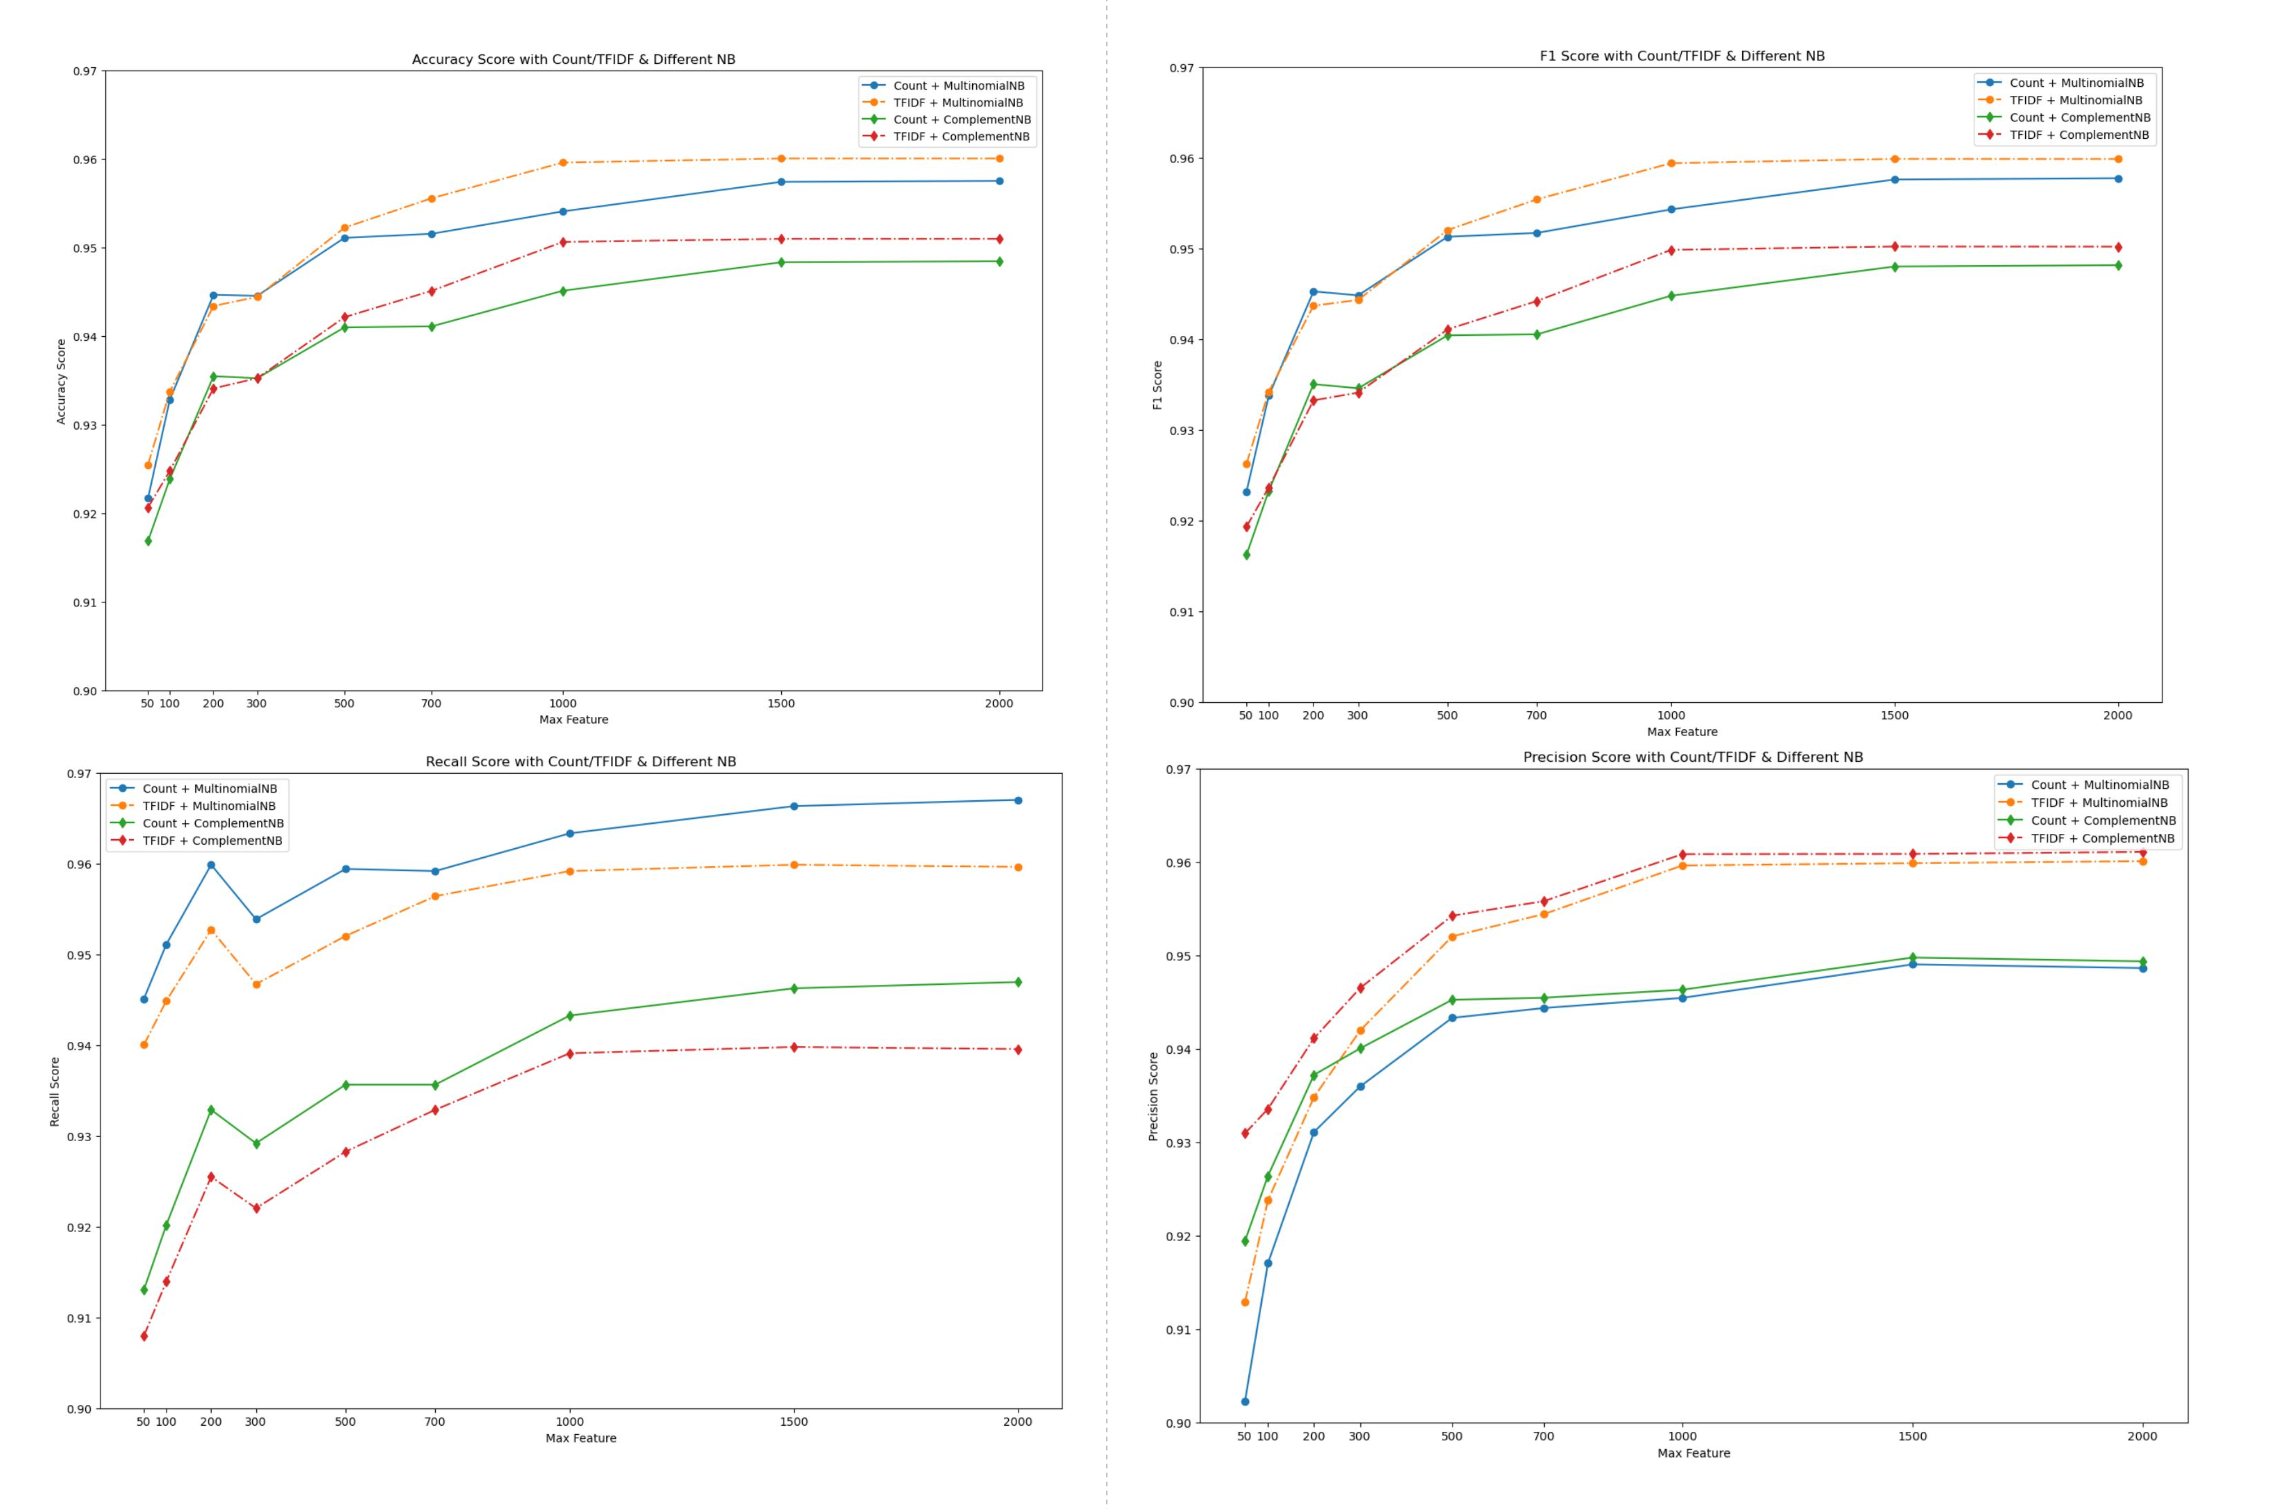

### 5.3 InBalanced: Ham > Spam

Since this section is just to help confirm on our guess that this model does not represent real-life, we randomly duplcate the ham emails to make it the majority class.

In [211]:
non_spam_df = data_frame.loc[data_frame["class"]==0]

spam_df = data_frame.loc[data_frame["class"]==1]
spam_amount = len(spam_df.index)

non_spam_df = non_spam_df.sample(n=spam_amount*2, replace=True)

moreham_data_frame = pd.concat([non_spam_df, spam_df])
moreham_data_frame = moreham_data_frame.sample(frac=1).reset_index(drop=True)

In [213]:
all_y = moreham_data_frame["class"].values  # all label values
all_x = moreham_data_frame.drop(columns=["class"]).values # all features' values

# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((128562,), (128562, 2), (102849, 2), (25713, 2), (102849,), (25713,))

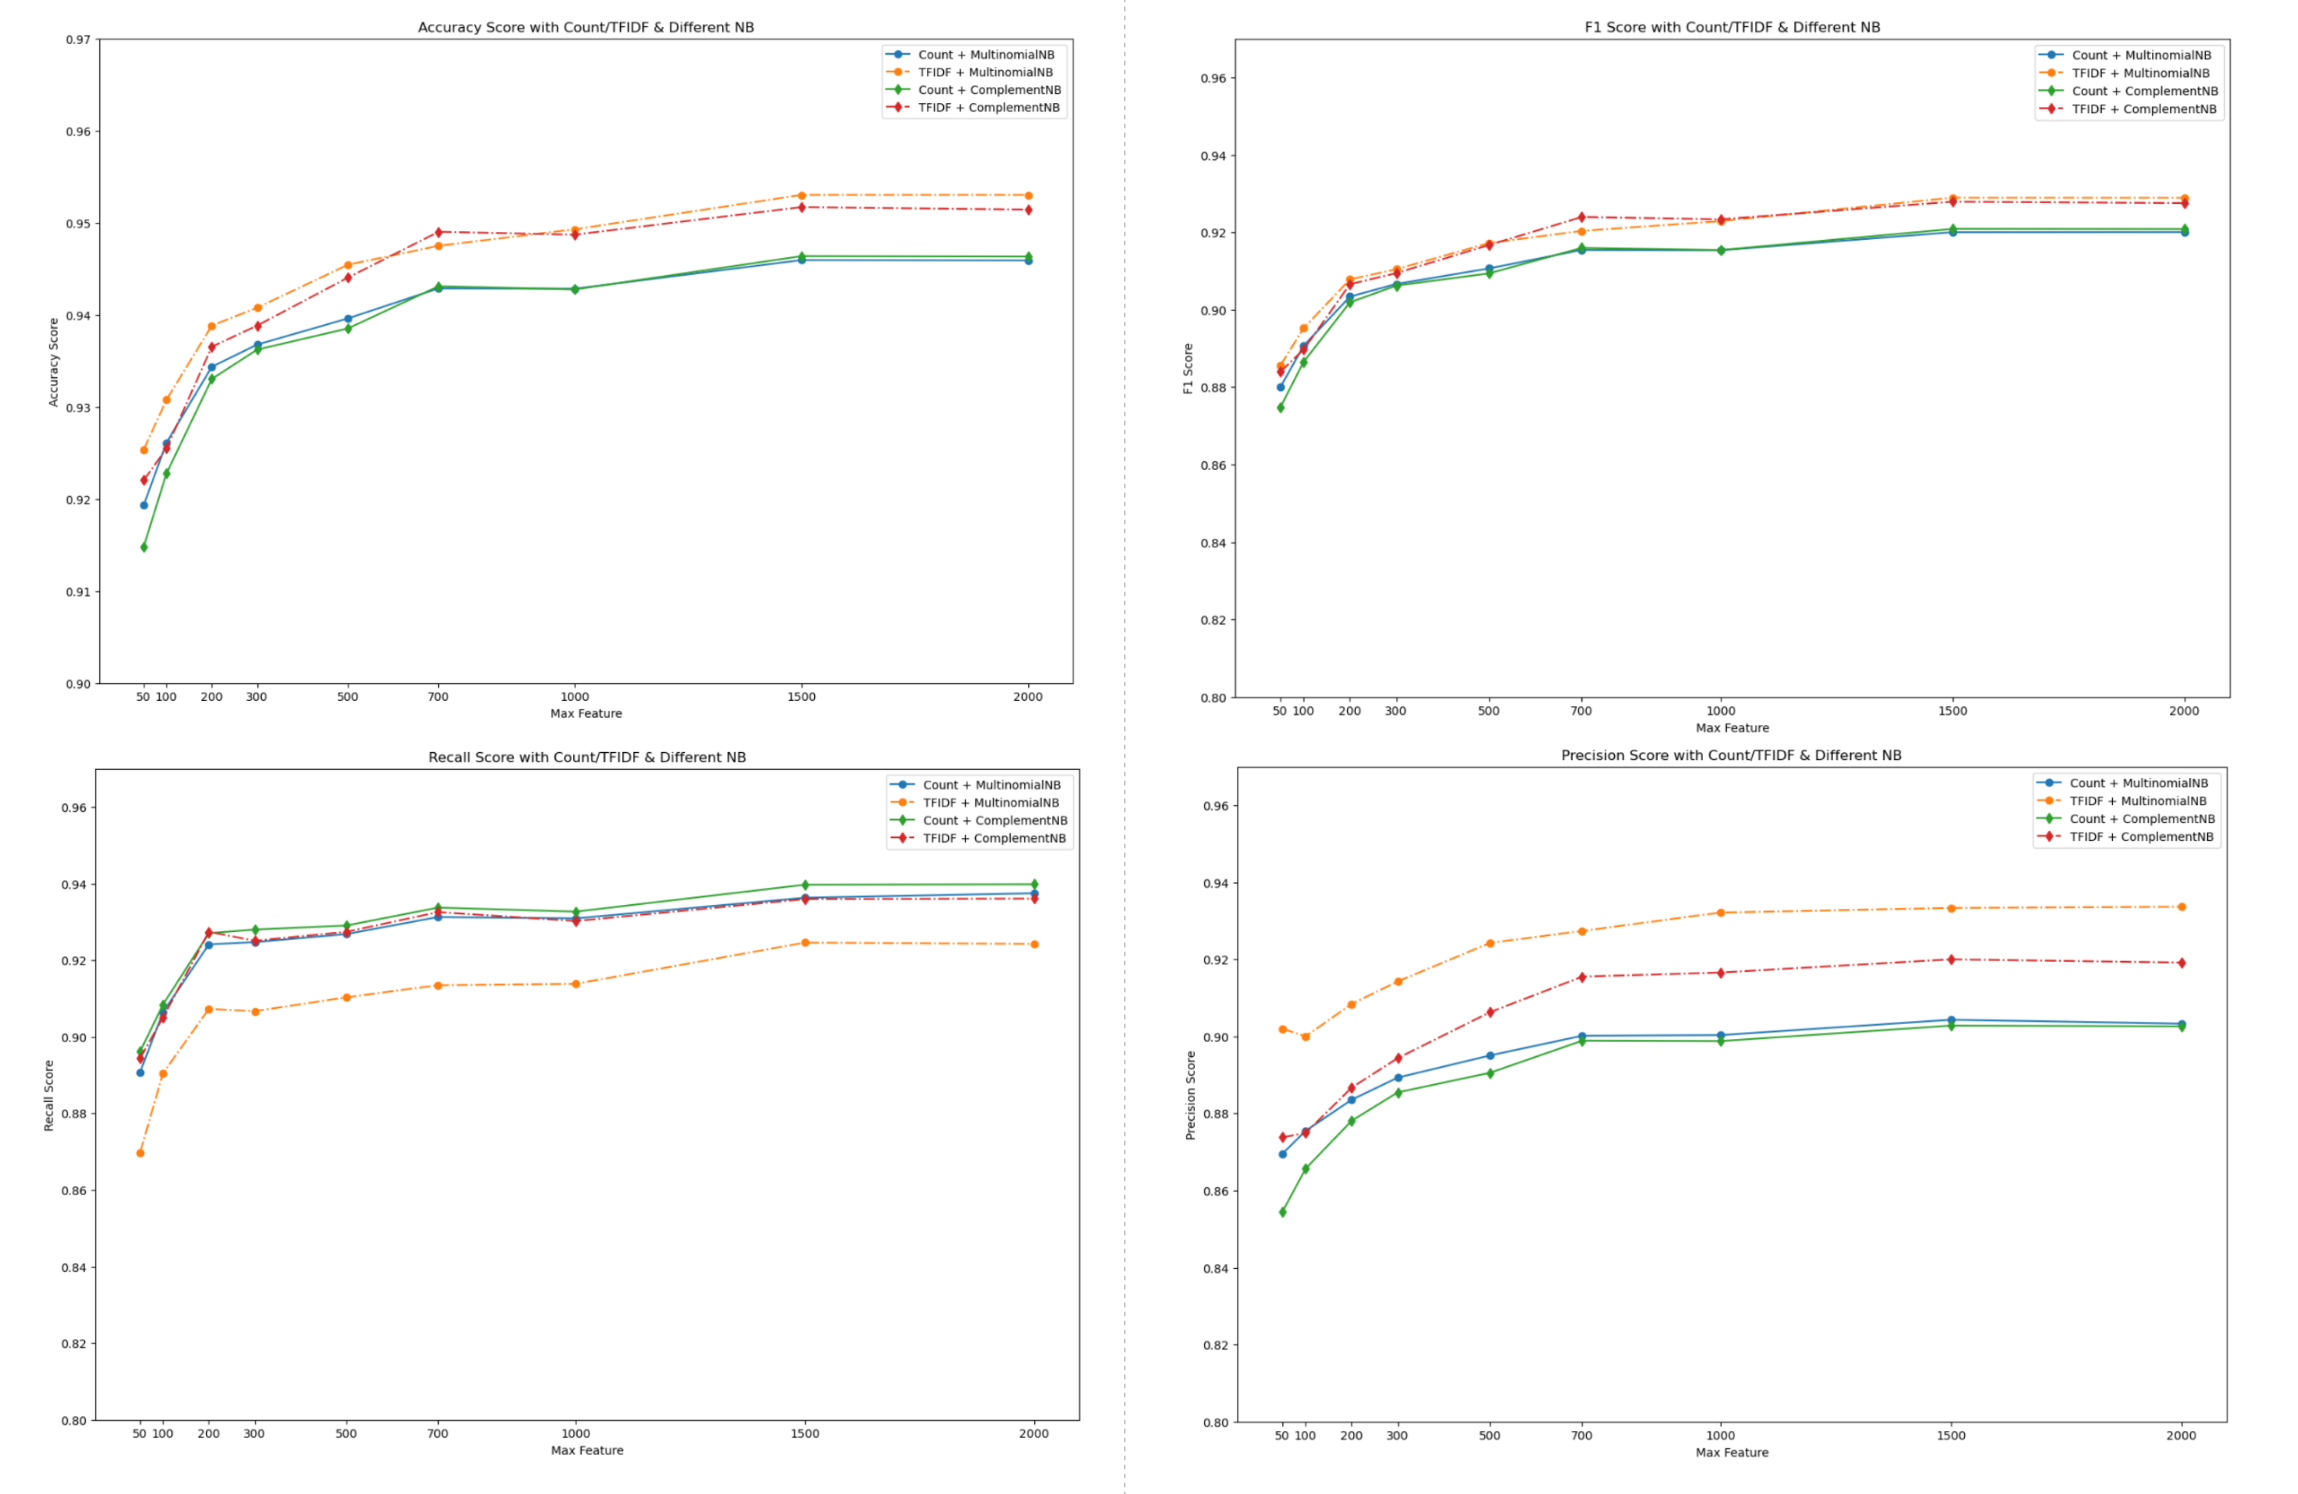

Although the way we re-sample the raw dataset to gradually increase the proportion of ham emails will introduce great bias, we can still get some rough ideas on how models behave on a dataset that has better representation of real life.  

For all tested model combinations, the scores remain an upward trend as the max feature amount increases. Compared to an imbalanced dataset with the majority class being spam emails, we can see that the overall performances (all 4 scores) start to drop as the ham emails increase.   
We can see that vectorization with TF-IDF performs better than Count, especially when ham emails become the majority class.  

Observations when there are more spams:  
1. TF-IDF + MultinomialNB has the best prediction accuracy and F1 score. 
2. TF-IDF + MultinomialNB and Count + ComplementNB have the best F1 scores(overlapped). 
3. TF-IDF + ComplementNB has the worst training result.
4. TF-IDF + ComplementNB has the best precision score and the lowest recall score.  

The reason behind this is that, although by definition, ComplementNB should work better on an imbalanced dataset, using TF-IDF will end up with the majority of words chosen being from the majority class(spam). Thus, an extra bias got introduced in.  

Observations when spam and ham have equal amounts:
1. TF-IDF + MultinomialNB has the best prediction accuracy and F1 score. 
2. Judging by accuracy scores and F1 scores, vectorization with TF-IDF produces more reliable predictions. 
3. Count + ComplementNB has the worst training result.
4. Count + MultinomialNB has the highest recall score and the lowest precision score.   

As the spam and ham amounts get balanced in the dataset, the bias on feature extraction from TF-IDF gets reduced.  
Observation 3 & 4 is due to the fact of the count vectorizer's inability in identifying more important and less important words for analysis.   
In Complement Naive Bayes, instead of calculating the probability of an item belonging to a specific class, we calculate the probability of an item being part of all classes. With the count vectorization and TF-IDF cannot effectively determine the importance of term features, complementNB still produces insufficient results.  

Observations when there are more hams:  
1. The TF-IDF vectorizer produces better results than the countvectorizer.
2. Accuracy scores and F1 scores for TF-IDF + MultinomialNB and TF-IDF + ComplementNB are close.
3. TF-IDF + MultinomialNB has the highest precision score and the lowest recall score, whilst TF-IDF + ComplementNB has stable performances on both precision and recall.
4. Recall scores with count vectorization are comparatively higher.  

The dataset class proportion here reflects the real situation better. Compared to the other two dataset, we have a poorer overall performance on filtering spam emails. The bias analyzed in "Observations when there are more spams" can explain this, as the bias now can mislead the spam emails detected as ham.   
In general, TF-IDF + ComplementNB has more stably-accurate behaviors in detecting spams. TF-IDF feature extraction enhances the importance of words for detecting ham emails and complementNB flattens out bias due to there being far less spam emails in the dataset.


In the later stage(Section6), we will be looking into the generalization of TF-IDF + MultinomialNB and TF-IDF + MultinomialNB.

## 6. Experiments

The data set used here is: https://www.kaggle.com/datasets/maharshipandya/email-spam-dataset-extended.  
This data set has more hams and less spams, which can be more representative to the real-life situation.

ref: https://www.hindawi.com/journals/scn/2022/1862888/   
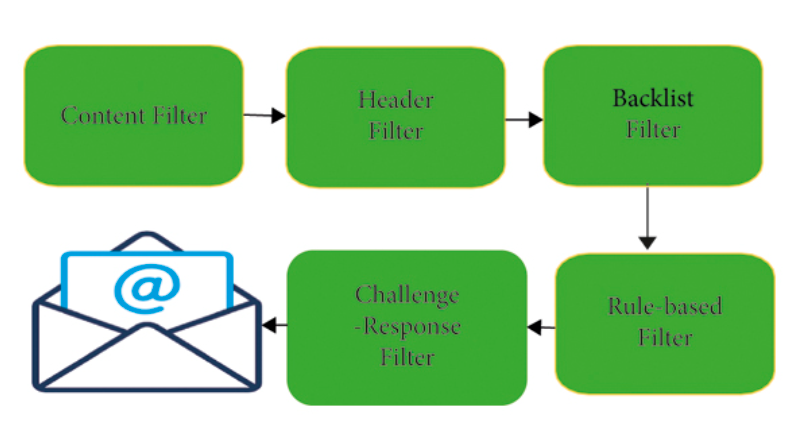  

The image above is a standard spam filtering system. Among which, the header filter, which extracts the header information from the email, is implemented after classifying by email contents.  
In this experiment, we will focus on content filtering and header filtering, as information such as backlist is not provided/accessible.  

Please see the <mark>"_bayes_expriment.ipynb"</mark> under the same directory.



### Section Summary

<mark>Best performance is:  the combination of content + from + to + date with Multinomial Naive Bayes  

accuracy: 0.9762443438914027 precision: 0.9347408829174664, recall: 0.9838383838383838, f1: 0.9586614173228347</mark>  


In this experiment, we use weighted class TF-IDF for vectorization. However, this would introduce in bias due to:  
1. When dataset is imbalanced, TF-IDF will end up with the majority of words chosen being from the majority class;  and this bias got strengthened by class weighted.
2. we use the terms extracted from one class samples as stop words during extraction for another class; the order to process classes can introduce in bias.  

<mark>What can be better:</mark>  
1. Vectorization ngram range hasn't been tested
2. We could possibly inverse the proportion of classes when doing weighted class TF-IDF. This needs further testing.
3. The information extracted from email headers, especially Date/Cc Account Amount, does not bring in sufficient improvements. Perhaps we should try other ways to pre-process them.  


<mark>Bayes Related</mark>:
This experiment uses all extracted information within one Naive Bayes classifier. Perhaps it would be better if we can separate the training and predicting to: 1. Content Based Filter; 2. Header Based Filter.
